In [15]:
# FEED ME SEVERAL GENESIS OUTPUT FILES

%load_ext autoreload
%autoreload 2
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib
import numpy as np
import scipy.integrate as sint
import scipy.optimize as sopt
from scipy.interpolate import interp1d
import scipy.special as sspec
import pandas as pd
import itertools
from multiprocessing import Pool
from shutil import copyfile
from IPython import display
from numba import jit
import os, sys
from stats import *
from matplotlib.ticker import FormatStrFormatter
from genesis import genesis, parsers, lattice, analysis, lattice_operations, bsub, writers, wakefields#, interactive

font = {#'family' : 'helvetica',
        #'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

colorlist=['#f3ffa0', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
!pwd

/sdf/group/beamphysics/jytang/genesis/CBXFEL/genesis_interface


In [17]:
basedir = '../data_long/'
# basedir = './run3_moreheater/'
files = np.array(os.listdir(basedir))
files = files[np.array(['tap' in file for file in files])]
#files = files[np.array(['K1.4' in file for file in files])]
files = files[np.array(['.ou' in file for file in files])]
files = files[np.array(['.log' not in file for file in files])]
files = files[np.array(['dfl' not in file for file in files])]
files = files[np.array(['K1.172_' in file for file in files])]
files = files[np.array(['nf4.ou' in file for file in files])]
#files = files[np.array(['n100' in file for file in files])]
files = files[np.array(['tap0.03' in file for file in files])]
files = np.array([basedir+file for file in files])
files = np.sort(files)
files

array(['../data_long/tap0.03_K1.172_nt28_nf4.out'], dtype='<U40')

In [18]:
# # fix filename trunc; .ou -> .out
# for f in files:
#     os.system('mv '+f+' '+f+'t')

In [19]:

#files = files[:3]
#files = ['./gaussianbeam_100mevp/gen_tap0.0_seed0_test.out']

In [20]:
filenames = files
showPlotQ = True
# if(len(sys.argv) > 1):
#     if sys.argv[1] == '-p' or sys.argv[1] == '-sp' or sys.argv[1] == '--plot' or sys.argv[1] == '--showplot':
#         showPlotQ = True
#         filenames = sys.argv[2:]
#         #filename = sys.argv[2]
#     else:
#         filenames = sys.argv[1:]
#         #filename = sys.argv[1]
# else:
#     print('Please specify a filename.')
#     break_code_error_check_me

records = []
for filename in filenames:
    record = {}

    basedir = '/'.join(filename.split('/')[:-1])
    workdir = basedir
    genoutfn = filename.split('/')[-1]
    fnhead = '.'.join(filename.split('/')[-1].split('.')[:-1])
    print('filename = ', filename)
    print('basedir = ', basedir)
    print('workdir = ', workdir)
    print('genoutfn = ', genoutfn)
    print('fnhead = ', fnhead)
    #break_code_xngdhgdjgdfj
    
    record['fnhead'] = fnhead
    record['genoutfn'] = genoutfn
    record['basedir'] = basedir
    record['workdir'] = workdir

    ## paths
    #basedir = '/gpfs/slac/staas/fs1/g/g.beamphysics/jduris'
    ##workdir = basedir+'/lh_shaping/LH_package_LCLSII_sc/elegant/scan_lower_edge_slopedwall/t0_-1_sigt_7_a0_0_a1_1_a2_1.5_a3_1_a4_10_l1p_-19.2_c1p_-148.97_l2p_-22.754_l3p_0.71_bc1_1_bc2_1.0201'#/genesis_charge_43pct_too_high'
    ##workdir += '/genesis_wcoefz_13.1_0.018_2'
    ##workdir += '/genesis_wcoefz_13.1_0.03_2'
    ##workdir += '/genesis_wcoefz_13.1_0.04_2'
    ##workdir += '/genesis_wcoefz_13.1_0.05_2'
    ##workdir += '/genesis_wcoefz_13.1_0.06_2'
    ##workdir += '/genesis_wcoefz_13.1_0.07_2' # best?
    ##workdir += '/genesis_wcoefz_13.1_0.08_2'
    ##workdir += '/genesis_wcoefz_20.25_0.018_2'
    ##workdir += '/genesis_wcoefz_20.25_0.03_2'
    #workdir = '/nfs/slac/g/beamphysics/jduris/lh_shaping/LH_package_LCLSII_sc/elegant/scan_sloped_wall_flatbeam_700A/t0_-1_dt_601793005265.1469_sigt_2_A_0_B_0_l1p_-19.2_c1p_-148.97_l2p_-20.754_l3p_0.71_bc1_1_bc2_1'
    ##fnhead = 'genesis'
    #fnhead = 'gen_tap_0.0001'
    ##fnhead = 'genesismp'
    savefolder = workdir

    # Setup generic genesis class
    params = {'workdir' : workdir,
            'genesis_bin' : 'genesis_BULLET',
            'input_file' : workdir + '/' + fnhead + '.in',
            'use_tempdir' : False}
    g = genesis.Genesis(**params)
    
    record['params'] = params
    record['g'] = g

    # Load Genesis output data
    g.load_output() # parse output
    zlist = np.asarray(g.output['lattice']['z'])
    slicedat = g.output['slice_data']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8
    slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8 * g.input['zsep']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    slist_fs = slist * 1e15
    outputdat=[];
    for ii in range(len(slicedat)):
        if np.mod(ii,150)==0: print(ii);
        temp = pd.DataFrame.from_dict(slicedat[ii]['data'])
        temp.insert(0, 'slice', slicedat[ii]['index'])
        temp.insert(0, 'current', slicedat[ii]['current'])
        temp.insert(0, 'z', zlist)
        outputdat.append(temp)
    outputdat = pd.concat(outputdat, axis = 0)
    display.clear_output(wait = True)
    print(outputdat.head())
    currlist = outputdat['current'].iloc[::len(zlist)]
    energylist_init = outputdat['energy'].iloc[::len(zlist)]
    energylist_fin = outputdat['energy'].iloc[len(zlist)-1::len(zlist)]
    
    record['zlist'] = zlist
    record['slicedat'] = slicedat
    record['awlist'] = np.asarray(g.output['lattice']['aw'])
    record['qflist'] = np.asarray(g.output['lattice']['qfld'])
    record['slist'] = slist
    record['slist_fs'] = slist_fs
    record['outputdat'] = outputdat
    record['currlist'] = currlist
    record['energylist_init'] = energylist_init
    record['energylist_fin'] = energylist_fin

    # print pulse energy
    zgroups = outputdat.groupby('z')
    slicegroups = outputdat.groupby('slice');
    pulse_energy = zgroups.agg({'power':'sum'})['power'] * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    print('Peak output power: {:2.2f} GW'.format(outputdat['power'].max() * 1e-9))
    print('Pulse energy from sum of output power: {:2.2f} uJ'.format(pulse_energy.values[-1] * 1e6))
    print('Peak current:', outputdat['current'].max()*1e-3, 'kA')
    print('Average current:', outputdat['current'].mean()*1e-3, 'kA')
    
    record['zgroups'] = zgroups
    record['slicegroups'] = slicegroups
    record['pulse_energy'] = pulse_energy
    
    records += [record]

def getmean(key, records=records):
    arr = np.array([rec[key] for rec in records])
    try:
        return np.mean(arr, axis=0)
    except:
        lens = [len(el) for el in arr]
        print("WARNING: unequal lengths for different files ",[len(el) for el in arr])
        arr = [a[:min(lens)] for a in arr]
        return np.mean(arr, axis=0)

def getmeanovers(key, records=records):
    slists = np.array([rec['slist_fs'] for rec in records])
    smin = np.max([min(slist) for slist in slists])
    smax = np.min([max(slist) for slist in slists])
    snum = np.int(np.mean([len(slist) for slist in slists]))
    slist0 = np.linspace(smin, smax, snum)
    
    arr = np.array([np.interp(slist0, rec['slist_fs'], rec[key]) for rec in records])
    try:
        return slist0, np.mean(arr, axis=0)
    except:
        lens = [len(el) for el in arr]
        print("WARNING: unequal lengths for different files ",[len(el) for el in arr])
        arr = [a[:min(lens)] for a in arr]
        return slist0, np.mean(arr, axis=0)

def getmeanpowers(records=records):
    pows = []
    for rec in records:
        ii = 0; iimax = len(rec['zgroups']) - 1.
        for name,group in rec['zgroups']:
            ii = ii + 1;
            if ii != len(zgroups): continue
            pows += [group['power'].values]
    try:
        return np.mean(pows, axis=0)
    except:
        lens = [len(el) for el in pows]
        print("WARNING: unequal lengths for different files ",[len(el) for el in pows])
        pows = [pow[:min(lens)] for pow in pows]
        return np.mean(pows, axis=0)
        
        

      z  current  slice        power     increment       p_mid   phi_mid  \
0  0.00   656.02      5  200000000.0  6.191600e-12  20372000.0  0.000000   
1  0.13   656.02      5  200000000.0 -5.551100e-14  20364000.0 -0.021430   
2  0.26   656.02      5  200000000.0 -1.964200e-13  20340000.0 -0.042847   
3  0.39   656.02      5  199940000.0 -1.202300e-02  20284000.0 -0.063825   
4  0.52   656.02      5  199870000.0 -1.255100e-02  20213000.0 -0.084748   

     r_size  energy  bunching  ...           <y>  e-spread     far_field  \
0  0.000011 -19.482  0.002577  ...  2.190700e-24    1.9569  2.181700e+20   
1  0.000011 -19.482  0.002582  ... -5.830200e-13    1.9569  2.181700e+20   
2  0.000011 -19.482  0.002591  ... -1.402000e-12    1.9569  2.181700e+20   
3  0.000011 -19.481  0.002668  ... -2.225100e-12    1.9585  2.181800e+20   
4  0.000011 -19.481  0.002877  ... -3.053500e-12    1.9623  2.181800e+20   

     4th_bunchin      4th_power      4th_phase      4th_p-mid    4th_far_fie  \
0  3.8

In [21]:
def strIntersection(s1, s2):
    out = ""
    for c in s1:
        if c in s2:# and not c in out:
            out += c
    return out

strint = files[0]
# for i in range(1,len(files)):
#     strint = strIntersection(strint,files[i])
#     print(strint)
# #     strIntersection('abcd','ac')

strint = strint.split('.')
strint = '.'.join(strint[:-1])

plotsdir = strint + '_'+str(len(files))+'files_plots'
savefolder = plotsdir

os.makedirs(plotsdir, exist_ok=True)
print('plots will go here:', plotsdir)

plots will go here: ../data_long/tap0.03_K1.172_nt28_nf4_1files_plots


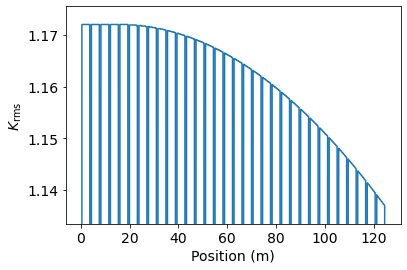

In [22]:
def plotunds(records=records,legendQ=True,merge_plots=False,figsize=None):
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    maxaw = 0.; minaw = 1e6;
    for rec in records:
        maxaw = np.max([np.max(record['awlist']),maxaw])
        minaw = np.min([np.min(record['awlist'][record['awlist']>0]),minaw])
        if legendQ:
            plt.plot(record['zlist'],record['awlist'],label=record['g'].input['outputfile'])
        else:
            plt.plot(record['zlist'],record['awlist'])
    plt.xlabel('Position (m)'); plt.ylabel('$K_\mathrm{rms}$')
    daw = maxaw - minaw; plt.ylim([minaw-0.1*daw,maxaw+0.1*daw]);
    if legendQ: plt.legend()
    if not merge_plots:
        figpath = os.path.join(plotsdir,'unds.png')
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
        plt.show()
# plotunds(records,legendQ=True)
plotunds(records,legendQ=False)

tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


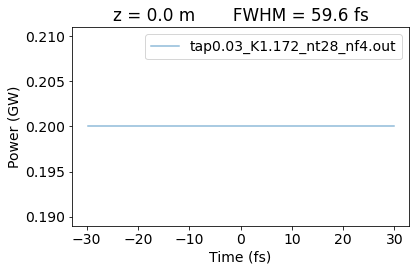

tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


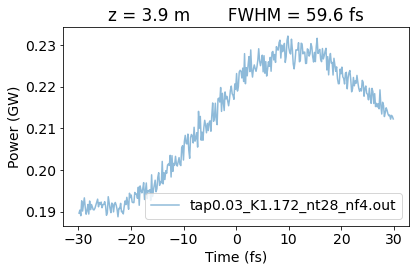

tap0.03_K1.172_nt28_nf4.out FWHM of power  34.46850866666667  fs


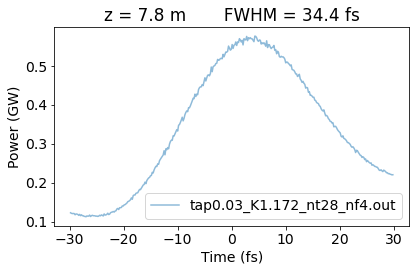

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.86691306666667  fs


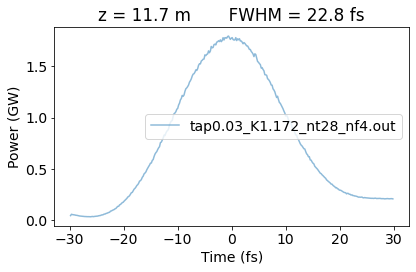

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.6722708  fs


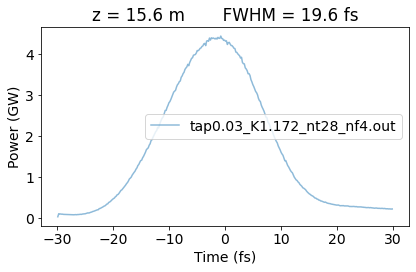

tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs


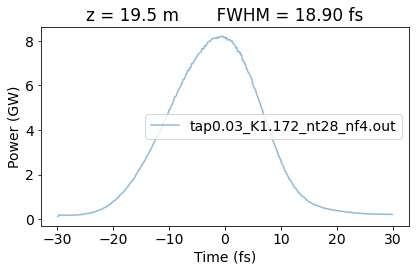

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.1678536  fs


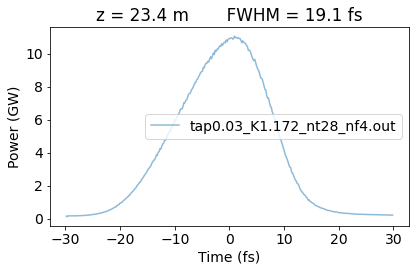

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.33599266666667  fs


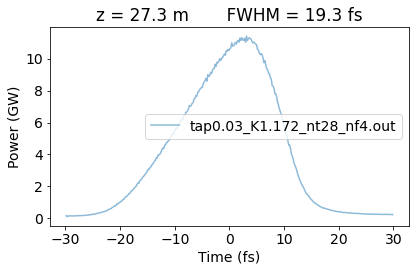

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.84040986666667  fs


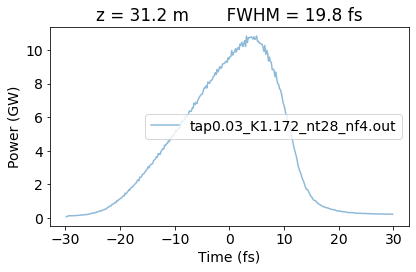

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.026217733333333  fs


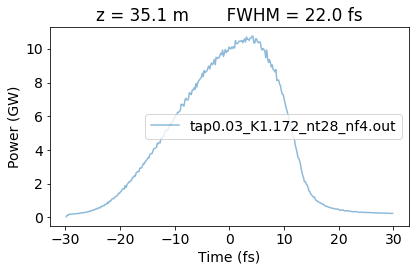

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.043886533333342  fs


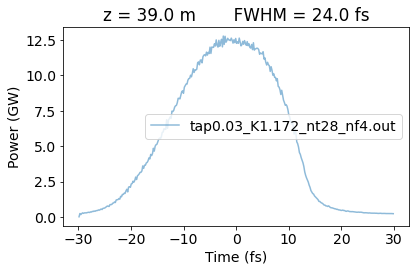

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.2120256  fs


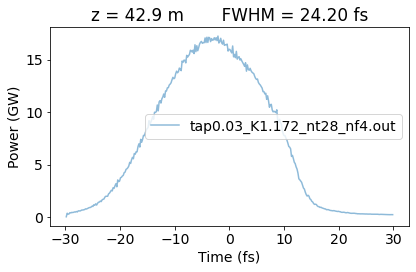

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.043886533333332  fs


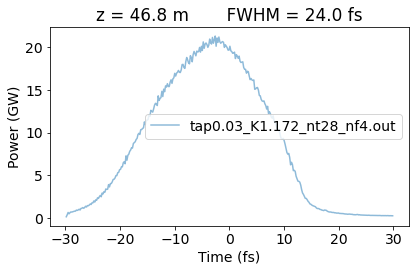

tap0.03_K1.172_nt28_nf4.out FWHM of power  25.220860000000002  fs


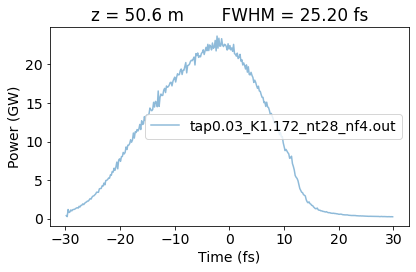

tap0.03_K1.172_nt28_nf4.out FWHM of power  26.061555333333335  fs


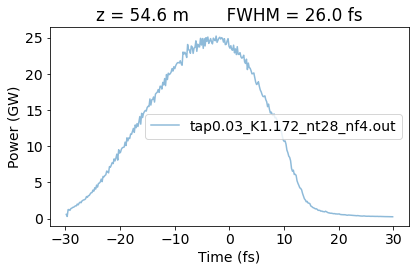

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.716442800000006  fs


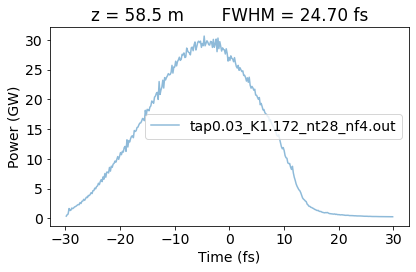

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333333  fs


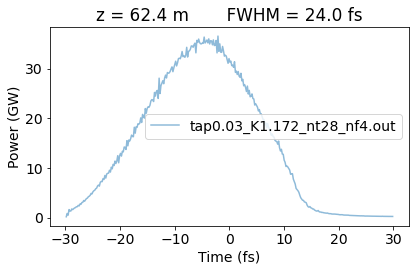

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333334  fs


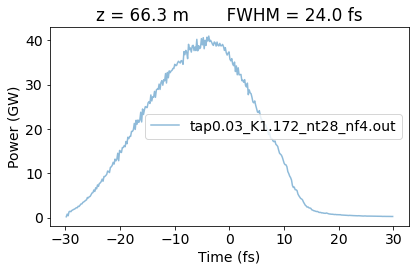

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333333  fs


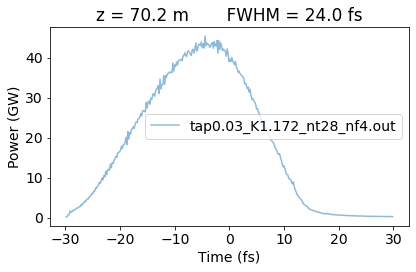

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666664  fs


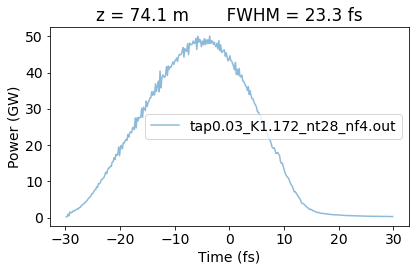

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.03505213333333  fs


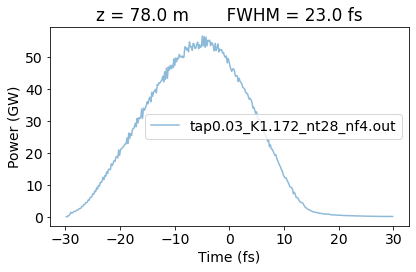

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666664  fs


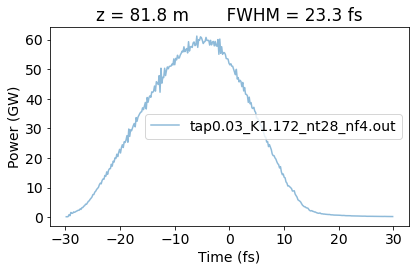

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.866913066666672  fs


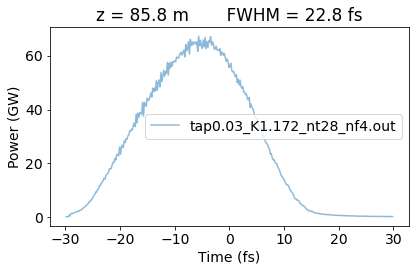

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.698773999999997  fs


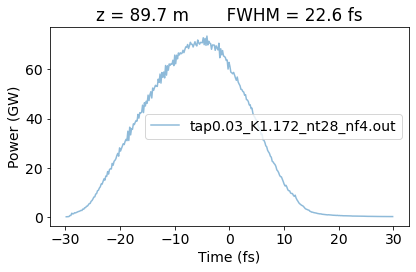

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.530634933333335  fs


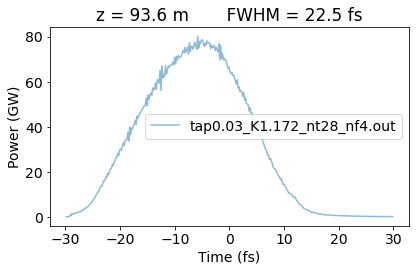

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.53063493333334  fs


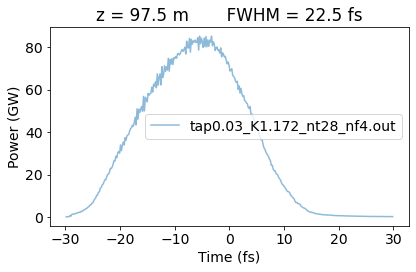

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.530634933333335  fs


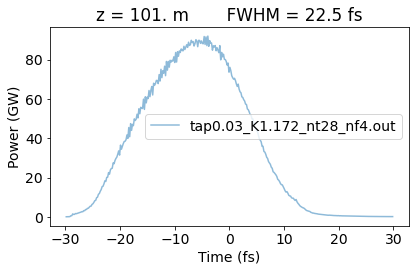

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.858078666666664  fs


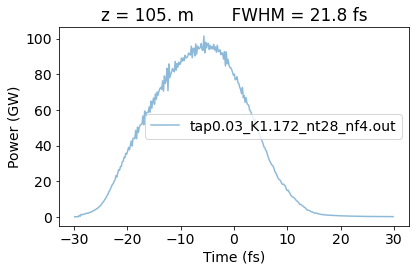

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.194356799999998  fs


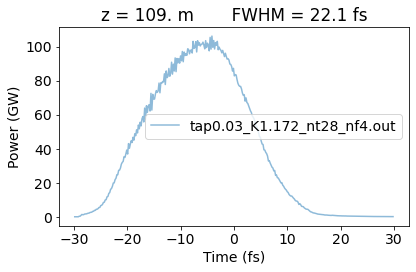

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.36249586666667  fs


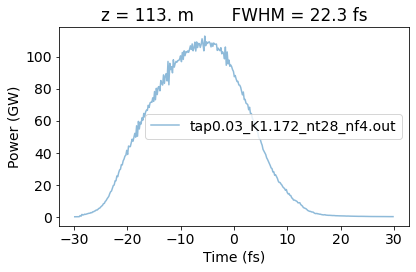

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.026217733333336  fs


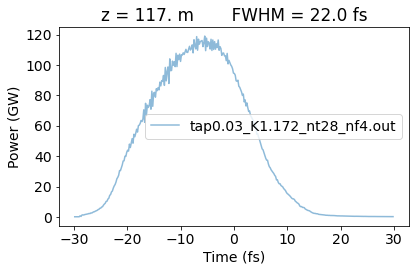

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.858078666666668  fs


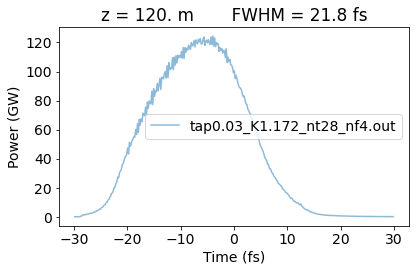

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.521800533333337  fs


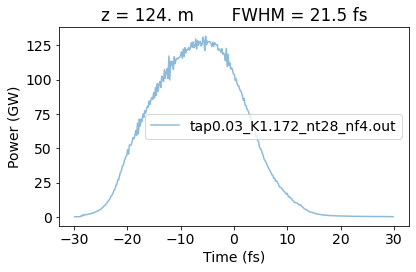

In [23]:
def get_powers(z,record):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    s = np.array(zg.slice) * g.input['xlamds'] / 3e8 * g.input['zsep']
    return s,np.array(zg.power)

def plot_powers(z,records,xlim=None,merge_plots=False,figsize=None):
    pows = []
    count = 0
    sfwhmlist = []
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    for rec in records:
        count += 1
        sl,pl = get_powers(z,rec); pows +=[pl]
        sl -= np.mean(sl)
        pdf = pl / (np.sum(pl))
        smean = np.sum(pdf * sl)
        s2mean = np.sum(pdf * sl**2)
        srms = np.sqrt(s2mean - smean**2)
        cdf = np.cumsum(pdf)
        smed = np.interp(0.5, cdf, sl); 
        s50=smed
        s10 = np.interp(0.1, cdf, slist_fs)
        s90 = np.interp(0.9, cdf, slist_fs)
        
        relpdf = pdf/max(pdf)
        slist50s = sl[relpdf > 0.5]*1e15
        slist10s = sl[relpdf > 0.1]*1e15
    
        sfwhmlist += [max(slist50s) - min(slist50s)] 
        print(files[count-1].split('/')[-1]+' FWHM of power ',sfwhmlist[-1],' fs')
        
        plt.plot(sl*1e15,pl*1e-9,alpha=0.5,label = files[count-1].split('/')[-1])
    #lens = [len(el) for el in pows]
    #pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)*1e-9
    #plt.plot(slist_fs[:len(mp)]-np.mean(slist_fs),mp,color='k')
        if xlim != None: plt.xlim(xlim)
        plt.xlabel('Time (fs)')
        plt.ylabel('Power (GW)')
        title = 'z = ' + str(z)[:4] + ' m       '
        title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        figpath = os.path.join(savefolder,'power_many_z'+str(np.int())+'.png')
        if not merge_plots:
            try:
                plt.savefig(figpath,bbox_inches='tight')
            except:
                print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_power_many.png', bbox_inches='tight')
            if showPlotQ: plt.show(); 
            plt.close()
    
Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_powers(z,records,figsize=(6,4))

Mask removes 88.34 %)


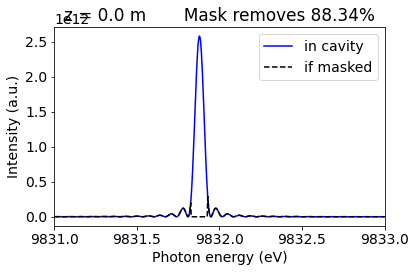

Mask removes 88.63 %)


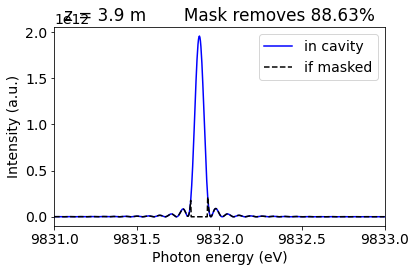

Mask removes 81.04 %)


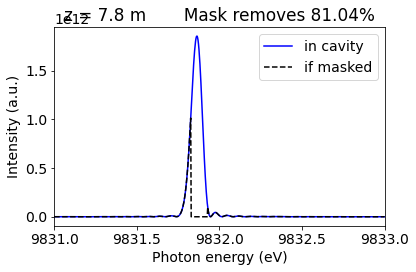

Mask removes 53.28 %)


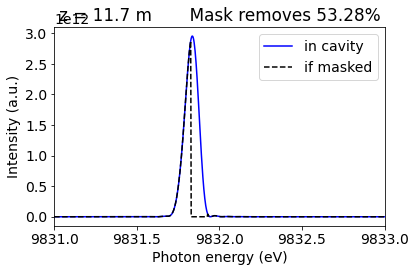

Mask removes 36.91 %)


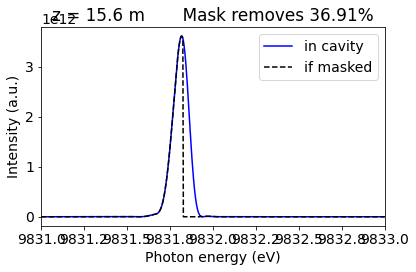

Mask removes 19.87 %)


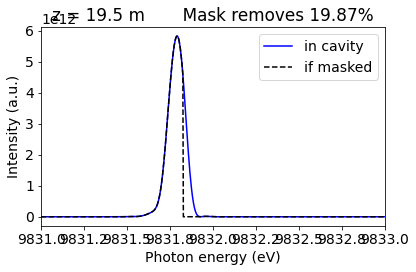

Mask removes 9.49 %)


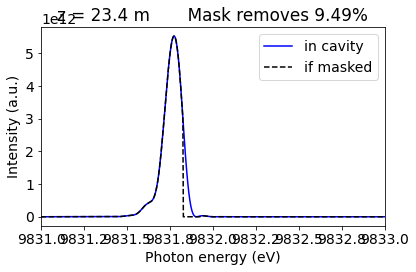

Mask removes 3.57 %)


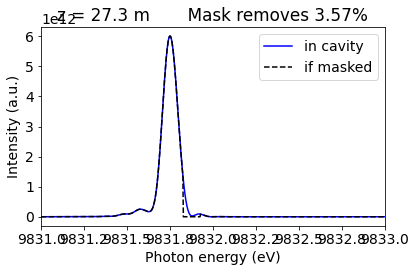

Mask removes 5.59 %)


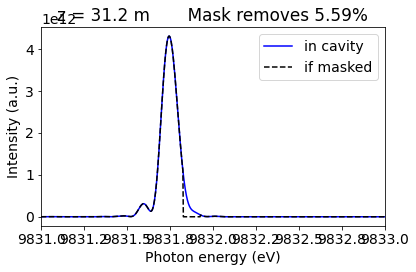

Mask removes 4.28 %)


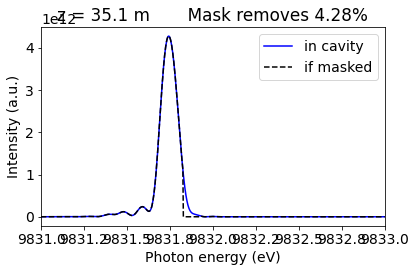

Mask removes 4.12 %)


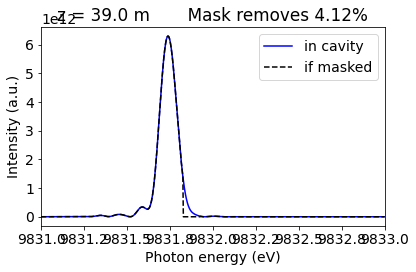

Mask removes 3.76 %)


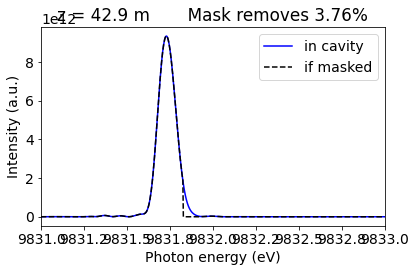

Mask removes 3.21 %)


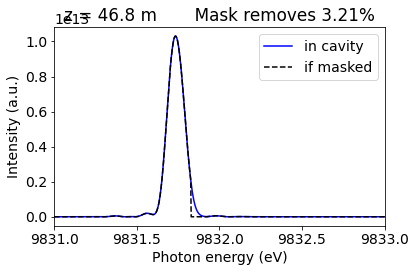

Mask removes 3.0 %)


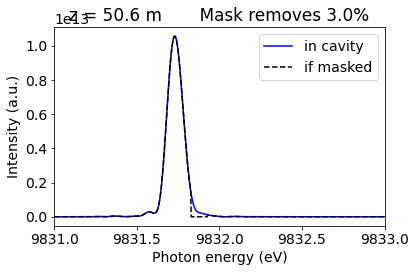

Mask removes 5.94 %)


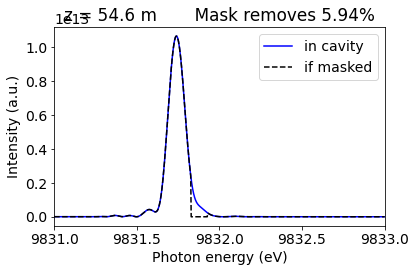

Mask removes 7.59 %)


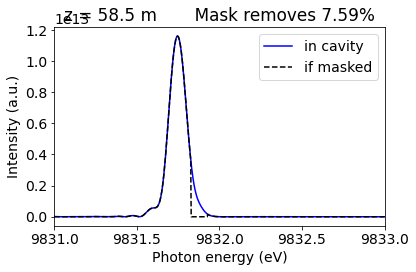

Mask removes 8.05 %)


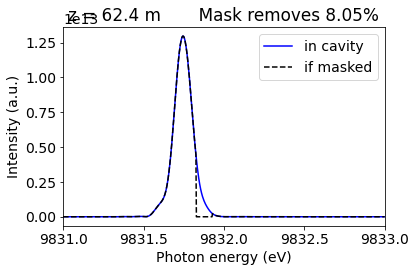

Mask removes 8.17 %)


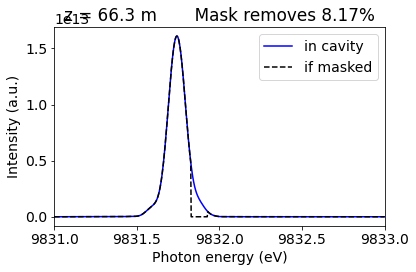

Mask removes 8.97 %)


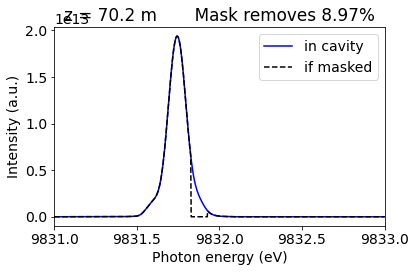

Mask removes 10.51 %)


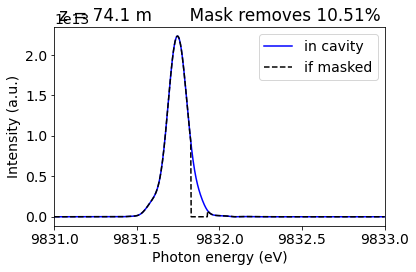

Mask removes 10.9 %)


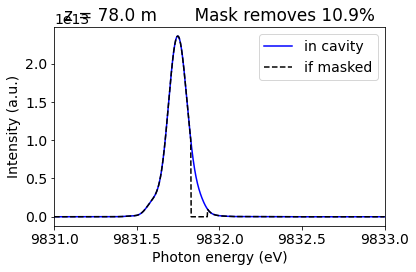

Mask removes 10.68 %)


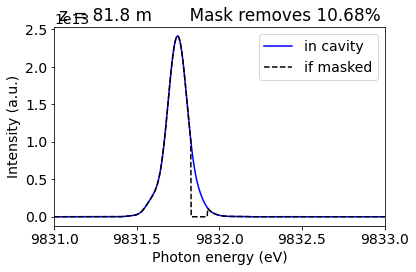

Mask removes 11.21 %)


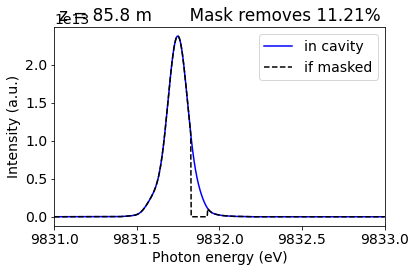

Mask removes 11.06 %)


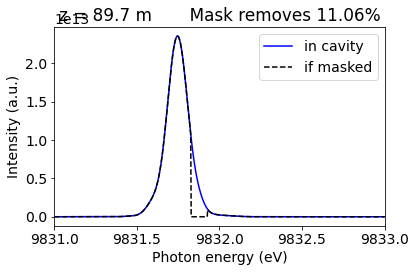

Mask removes 11.05 %)


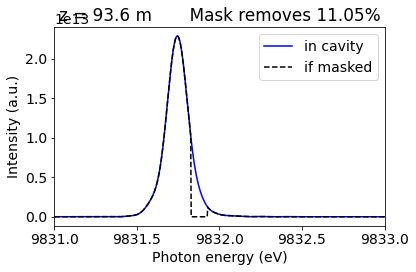

Mask removes 11.21 %)


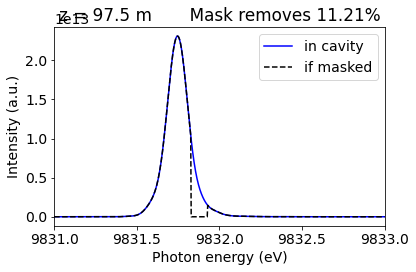

Mask removes 12.22 %)


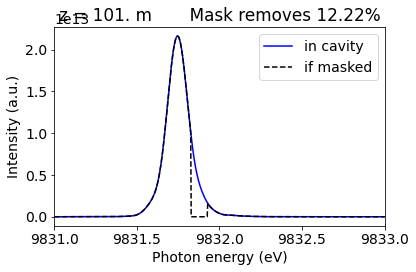

Mask removes 12.54 %)


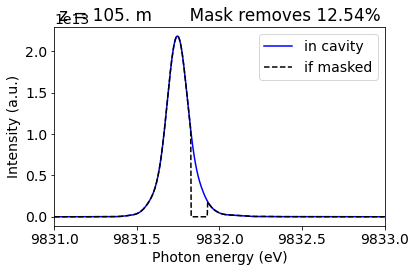

Mask removes 12.39 %)


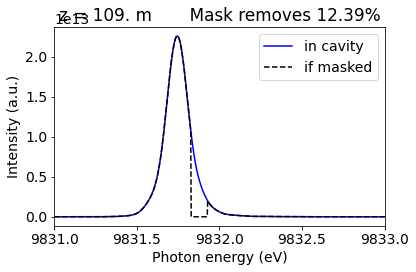

Mask removes 12.79 %)


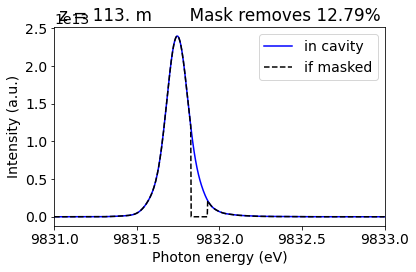

Mask removes 13.22 %)


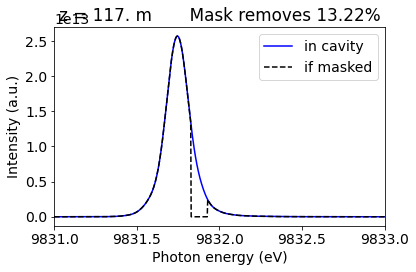

Mask removes 13.43 %)


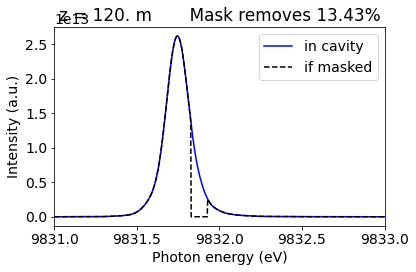

Mask removes 13.04 %)


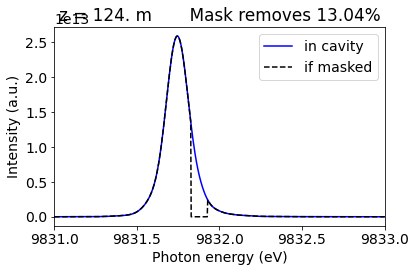

In [24]:
def get_spectra(z, record, mask_width_eV=None, mask_center_eV=None, npad = 4000):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    dt = g.input['xlamds'] / 3e8 * g.input['zsep']
    temp = np.array(zg.slice)
    sep = temp[1] - temp[0]
    s = np.array(zg.slice) * dt
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    s_fs = s*1e15
    
    s2 = np.arange(s.shape[0] + 2*npad) * dt*sep
    s_fs2 = s2*1e15
    
    
    h_Plank = 4.135667696e-15
    c_speed  = 299792458
    
    ws = np.arange(s_fs.shape[0]) / (s_fs[-1] - s_fs[0])
    ws -= np.mean(ws)
    hw0 =  h_Plank * c_speed /g.input['xlamds']
    hws = h_Plank*1e15  * ws + hw0
    
    
    
    ws = np.arange(s_fs2.shape[0]) / (s_fs2[-1] - s_fs2[0])
    ws -= np.mean(ws)
    hw0 = h_Plank * c_speed/g.input['xlamds']
    hws = h_Plank*1e15 * ws + hw0
    

    if mask_center_eV == None:
        mask_center_eV = hw0
    if mask_width_eV == None:
        useMask = False
        mask_width_eV = 100e-3
    else:
        useMask = True
    
    mask = (np.abs(hws - mask_center_eV) > 0.5 * mask_width_eV) * 1.

    
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    field = np.pad(field, (npad, npad))
    ftfld = np.fft.fftshift(np.fft.fft(field))
    spectra = np.abs(ftfld)**2
    #spectra /= np.max(spectra)
    
    if useMask:
        shot_fluence_uJperum2 = np.sum(spectra) * (hws[1] - hws[0])
        transmitted_shot_fluence_uJperum2 = np.sum(mask * spectra) * (hws[1] - hws[0])
        netrm = np.around(shot_fluence_uJperum2-transmitted_shot_fluence_uJperum2,2)
        pctrm = np.around(100.*(1.-transmitted_shot_fluence_uJperum2/shot_fluence_uJperum2),2)
        print('Mask removes',pctrm,'%)')
        return hws, spectra, mask, netrm, pctrm
    else:
        return hws, spectra

def plot_spectra(z,records,mask_width_eV=100e-3,xlim=None,ylim = None,merge_plots=False,figsize=None):
    pows = []
    if figsize != None:
        #plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    count = 0
    for rec in records:
        count += 1
        sl,pl,mask,netrm,pctrm = get_spectra(z,rec,mask_width_eV=mask_width_eV); pows +=[pl]
        #sl -= np.mean(sl)
        label_prefix = files[count-1].split('/')[-1]
        label_prefix = ''
        plt.plot(sl,pl,alpha=1,label = label_prefix + 'in cavity',color = 'b')
        plt.plot(sl,pl*mask,alpha=1,label = label_prefix + 'if masked', color = 'k',linestyle='dashed')
        ax = plt.gca()
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        hw0 = 1240.e-9/g.input['xlamds']
        #plt.axvline(x = hw0 - mask_width_eV/2, linestyle = 'dashed')
        #plt.axvline(x = hw0 + mask_width_eV/2, linestyle = 'dashed')
        plt.legend()
        #plt.plot(sl,mask, alpha = 0.5, label = label_prefix + 'filter')
    lens = [len(el) for el in pows]
    pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)
    #plt.plot(sl[:len(mp)],mp*mask,color='k')
    #plt.plot(sl[:len(mp)],mp,color='k')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
#     plt.legend()
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    title = 'z = ' + str(z)[:4] + ' m       '
#     title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
    title += 'Mask removes '+str(pctrm)+'%'
    plt.title(title)
    plt.tight_layout()
#     plt.savefig(savefolder+'/'+fnhead+'_output_spectra_many.png', bbox_inches='tight')
    figpath = os.path.join(savefolder,'spectra_many_z'+str(np.int())+'.png')
    if not merge_plots:
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
        if showPlotQ: plt.show(); 
        plt.close()


Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_spectra(z,records,figsize=(6,4), xlim = [9831, 9833])

Mask removes 0.03 uJ/um^2 ( 100.0 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


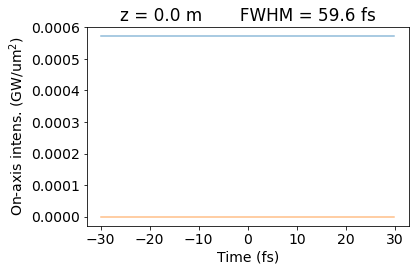

Mask removes 0.03 uJ/um^2 ( 99.96 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


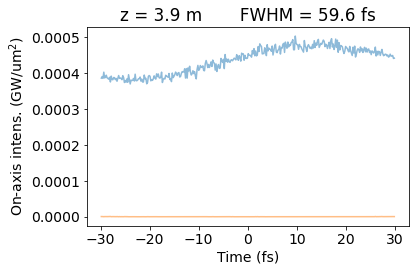

Mask removes 0.03 uJ/um^2 ( 99.62 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  30.265032000000012  fs


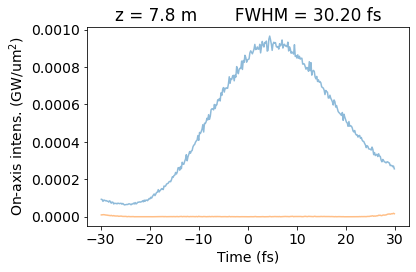

Mask removes 0.05 uJ/um^2 ( 92.37 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  22.19435680000001  fs


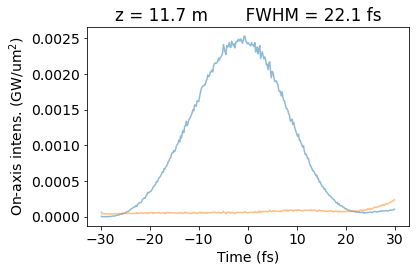

Mask removes 0.06 uJ/um^2 ( 80.99 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.831575466666674  fs


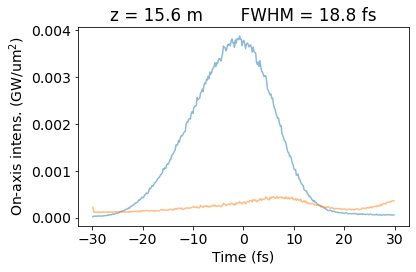

Mask removes 0.08 uJ/um^2 ( 61.79 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.654602  fs


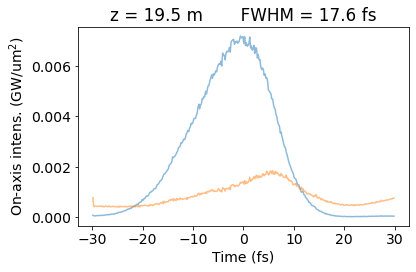

Mask removes 0.06 uJ/um^2 ( 43.47 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.32715826666667  fs


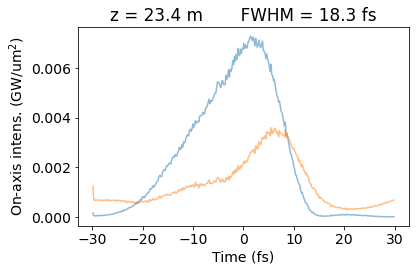

Mask removes 0.03 uJ/um^2 ( 25.82 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  23.035052133333338  fs


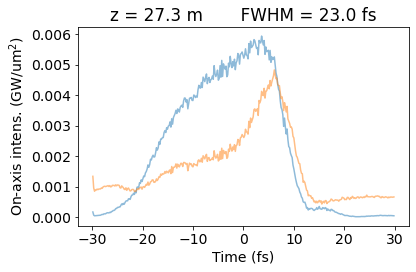

Mask removes 0.03 uJ/um^2 ( 26.68 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  25.22086  fs


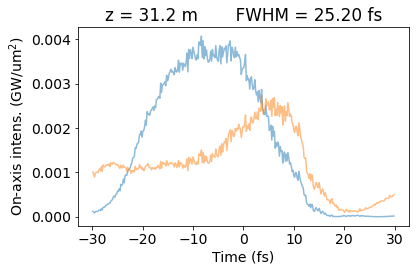

Mask removes 0.03 uJ/um^2 ( 25.13 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  26.229694400000007  fs


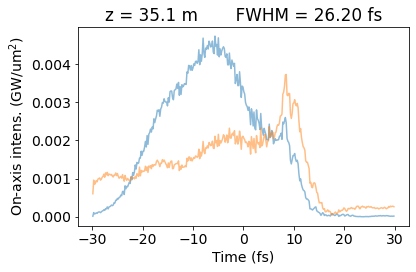

Mask removes 0.03 uJ/um^2 ( 22.07 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.504131733333335  fs


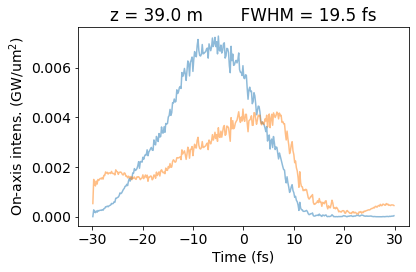

Mask removes 0.04 uJ/um^2 ( 19.22 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.486462933333332  fs


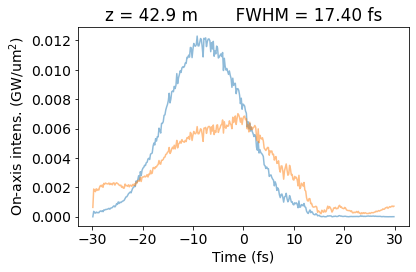

Mask removes 0.05 uJ/um^2 ( 19.93 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.512966133333343  fs


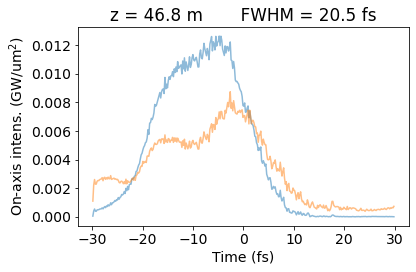

Mask removes 0.04 uJ/um^2 ( 16.38 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666668  fs


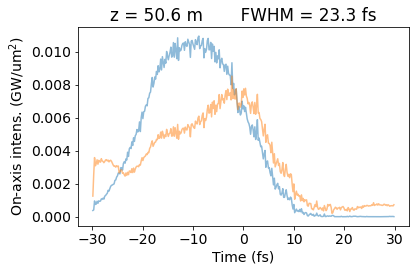

Mask removes 0.06 uJ/um^2 ( 23.19 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  21.017383333333335  fs


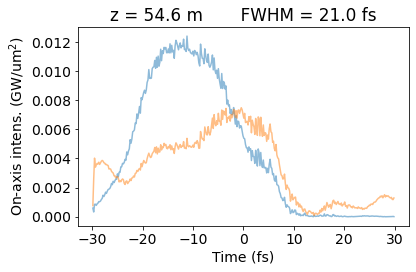

Mask removes 0.09 uJ/um^2 ( 28.57 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.49529733333334  fs


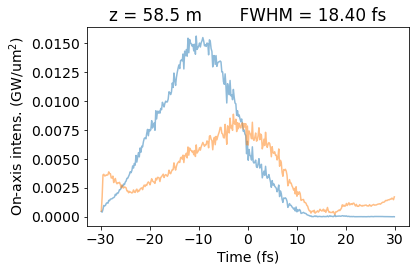

Mask removes 0.1 uJ/um^2 ( 28.7 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.6722708  fs


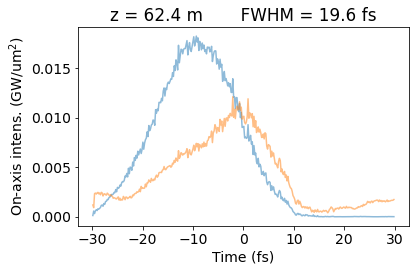

Mask removes 0.12 uJ/um^2 ( 26.55 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.512966133333336  fs


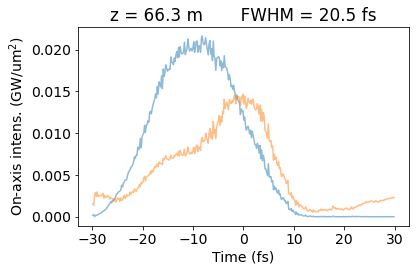

Mask removes 0.15 uJ/um^2 ( 27.78 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.344827066666667  fs


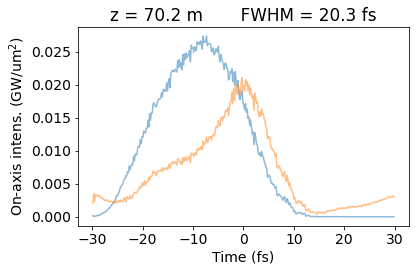

Mask removes 0.21 uJ/um^2 ( 30.52 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs


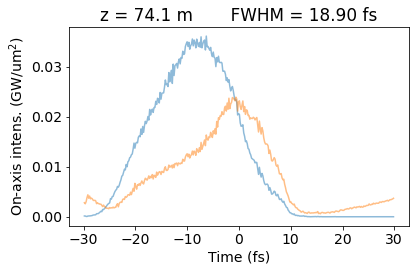

Mask removes 0.23 uJ/um^2 ( 31.15 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.83157546666667  fs


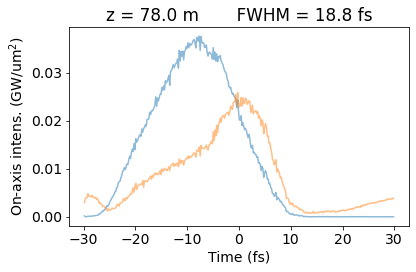

Mask removes 0.23 uJ/um^2 ( 30.06 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.51296613333333  fs


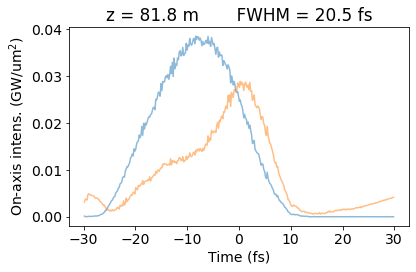

Mask removes 0.24 uJ/um^2 ( 30.99 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.159019200000003  fs


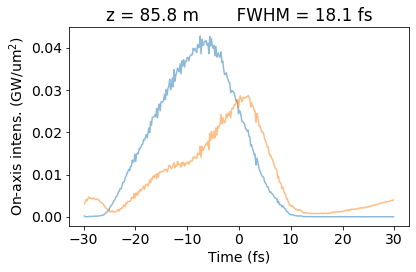

Mask removes 0.24 uJ/um^2 ( 30.88 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.31832386666667  fs


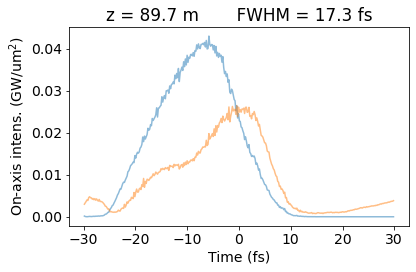

Mask removes 0.23 uJ/um^2 ( 30.15 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.1678536  fs


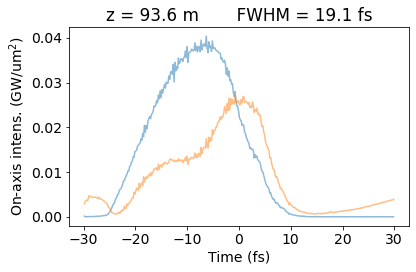

Mask removes 0.23 uJ/um^2 ( 30.4 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.504131733333338  fs


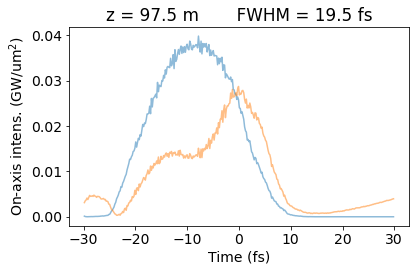

Mask removes 0.23 uJ/um^2 ( 31.37 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.33599266666667  fs


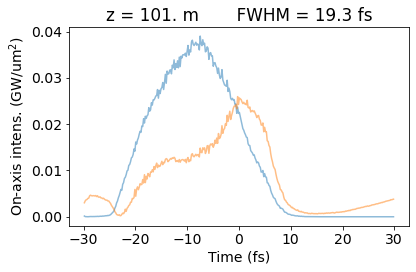

Mask removes 0.24 uJ/um^2 ( 31.06 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.008548933333334  fs


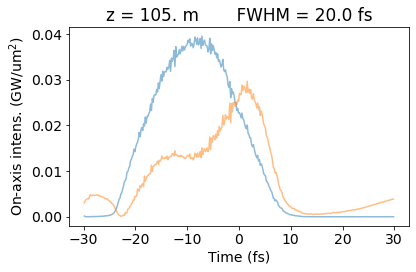

Mask removes 0.24 uJ/um^2 ( 30.48 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.840409866666665  fs


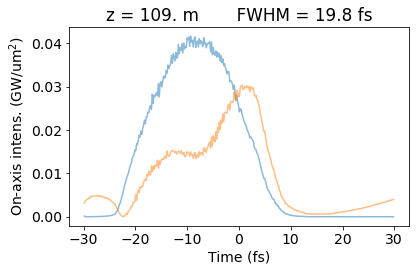

Mask removes 0.27 uJ/um^2 ( 30.92 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.50413173333333  fs


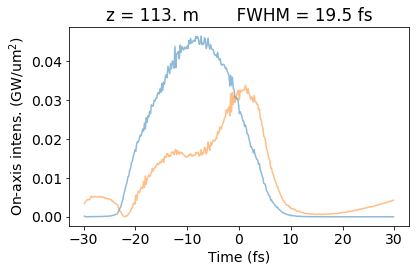

Mask removes 0.3 uJ/um^2 ( 31.4 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.831575466666667  fs


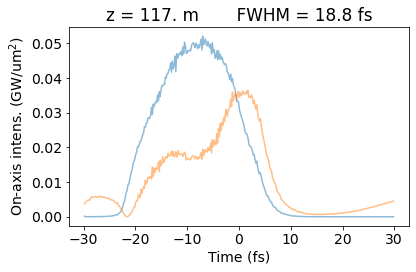

Mask removes 0.31 uJ/um^2 ( 31.61 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.167853600000004  fs


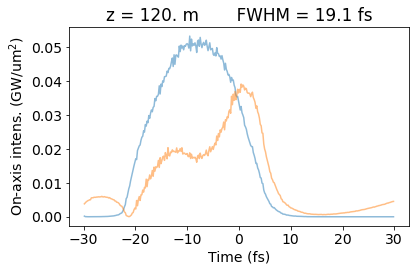

Mask removes 0.3 uJ/um^2 ( 31.09 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs


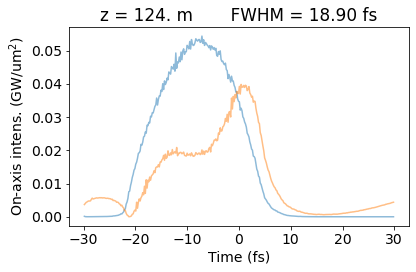

In [25]:
def get_pmid(z, record, mask_width_eV=None, mask_center_eV=None):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    s = np.array(zg.slice) * g.input['xlamds'] / 3e8 * g.input['zsep']
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    
    s_fs = s*1e15
    ws = np.arange(len(s_fs)) / (s_fs[-1] - s_fs[0])
    ws -= np.mean(ws)
    hw0 = 1240.e-9/g.input['xlamds']
    hws = 4.135 * ws + hw0

    if mask_center_eV == None:
        mask_center_eV = hw0
    if mask_width_eV == None:
        useMask = False
        mask_width_eV = 100e-3
    else:
        useMask = True
    
    mask = (np.abs(hws - mask_center_eV) > 0.5 * mask_width_eV) * 1.

    darea_m2 = (2. * g.input['dgrid'] / g.input['ncar'])**2 # area (m^2) of pixel in fld grid
    darea_mm2 = darea_m2 * 1e6
    darea_um2 = darea_mm2 * 1e6
    
    shot_fluence_uJperum2 = np.sum(pmid) * (s_fs[1] - s_fs[0]) * 1.e-15 * 1.e6 / darea_um2
    pmid *= 1e-6 * shot_fluence_uJperum2 / (s_fs[1] - s_fs[0]) / 1.e-15 * 1.e-9 / np.sum(pmid) # units GW/um^2
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    ftfld = np.fft.fftshift(np.fft.fft(field))
    spectra = np.abs(ftfld)**2
    spectra *= shot_fluence_uJperum2 / (hws[1] - hws[0]) / np.sum(spectra) # normalized: uJ/mm^2/eV
    
    if useMask:
        transmitted_shot_fluence_uJperum2 = np.sum(mask * spectra) * (hws[1] - hws[0])
        netrm = np.around(shot_fluence_uJperum2-transmitted_shot_fluence_uJperum2,2)
        pctrm = np.around(100.*(1.-transmitted_shot_fluence_uJperum2/shot_fluence_uJperum2),2)
        print('Mask removes',netrm,'uJ/um^2 (',pctrm,'%)')
        ftfld_masked = ftfld * np.sqrt(mask)
        pmid_masked = np.abs((np.fft.ifft(np.fft.ifftshift(ftfld_masked)))**2)
        ftfld_returned = ftfld * np.sqrt(1-mask)
        pmid_returned = np.abs((np.fft.ifft(np.fft.ifftshift(ftfld_returned)))**2)
        return s, pmid, pmid_masked, pmid_returned, netrm, pctrm
    else:
        return s, pmid

def plot_pmid(z,records,mask_width_eV=100e-3,xlim=None,ylim = None,merge_plots=False,figsize=None):
    pows = []
    count = 0
    sfwhmlist = []
    pctrmlist = []
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    for rec in records:
        count += 1
#         sl,pl = get_powers(z,rec); 
        sl,pl,plmasked,pmid_returned,netrm,pctrm = get_pmid(z,rec,mask_width_eV=mask_width_eV); pows +=[pl]
        pows +=[pl]
        pctrmlist += [pctrm]
        sl -= np.mean(sl)
        
        pdf = pl / (np.sum(pl))
        smean = np.sum(pdf * sl)
        s2mean = np.sum(pdf * sl**2)
        srms = np.sqrt(s2mean - smean**2)
        cdf = np.cumsum(pdf)
        smed = np.interp(0.5, cdf, sl); 
        s50 = smed
        s10 = np.interp(0.1, cdf, slist_fs)
        s90 = np.interp(0.9, cdf, slist_fs)
        
        relpdf = pdf/max(pdf)
        slist50s = sl[relpdf > 0.5]*1e15
        slist10s = sl[relpdf > 0.1]*1e15
    
        sfwhmlist += [max(slist50s) - min(slist50s)] 
        print(files[count-1].split('/')[-1]+' FWHM of power ',sfwhmlist[-1],' fs')
        
        label_prefix = files[count-1].split('/')[-1]
        label_prefix = ''
        plt.plot(sl*1e15,pl,alpha=0.5,label = label_prefix+'in cavity')
        plt.plot(sl*1e15,plmasked,alpha=0.5,label = label_prefix+'if masked')
    #lens = [len(el) for el in pows]
    #pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)*1e-9
    #plt.plot(slist_fs[:len(mp)]-np.mean(slist_fs),mp,color='k')
        if xlim != None: plt.xlim(xlim)
        plt.xlabel('Time (fs)')
        plt.ylabel('On-axis intens. (GW/um$^2$)')
        title = 'z = ' + str(z)[:4] + ' m       '
        title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
        plt.title(title)
#         plt.legend()
        plt.tight_layout()
        figpath = os.path.join(savefolder,'intensity_many_z'+str(np.int())+'.png')
        if not merge_plots:
            try:
                plt.savefig(figpath,bbox_inches='tight')
            except:
                print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_intens_many.png', bbox_inches='tight')
            if showPlotQ: plt.show(); 
            plt.close()


Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_pmid(z,records,figsize=(6,4))

tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs
Mask removes 88.34 %)
Mask removes 0.03 uJ/um^2 ( 100.0 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


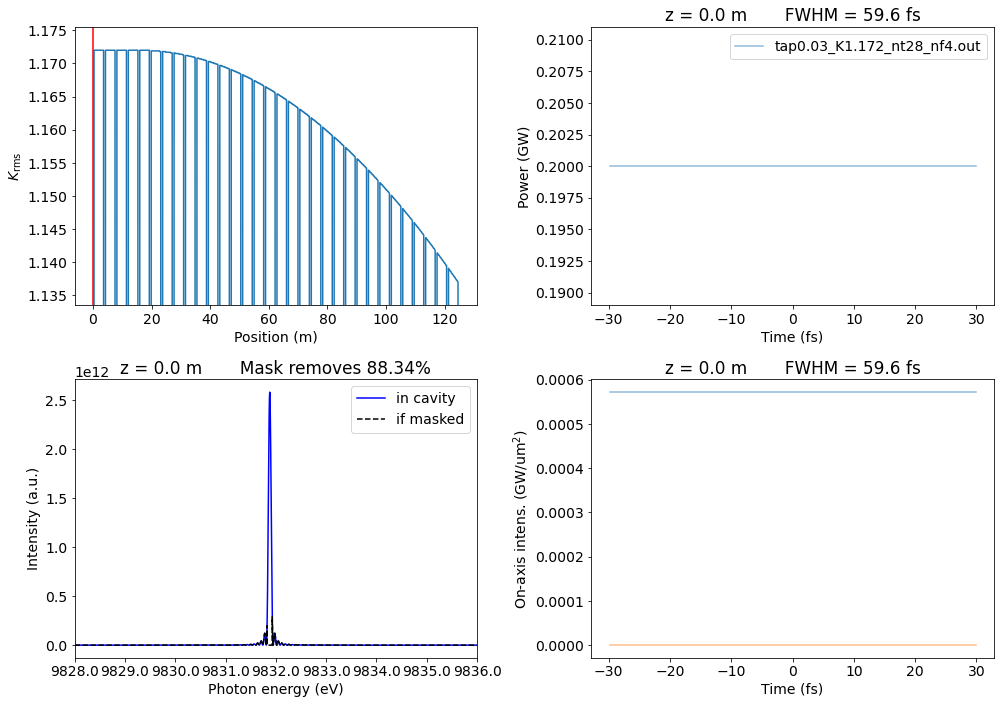

tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs
Mask removes 88.63 %)
Mask removes 0.03 uJ/um^2 ( 99.96 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  59.68936866666667  fs


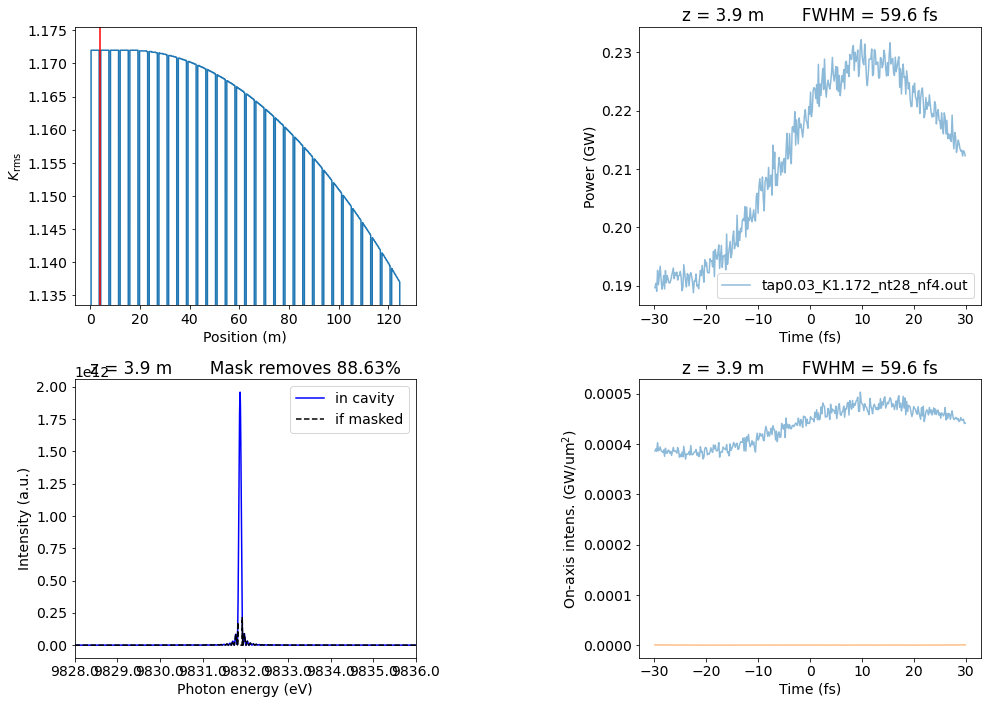

tap0.03_K1.172_nt28_nf4.out FWHM of power  34.46850866666667  fs
Mask removes 81.04 %)
Mask removes 0.03 uJ/um^2 ( 99.62 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  30.265032000000012  fs


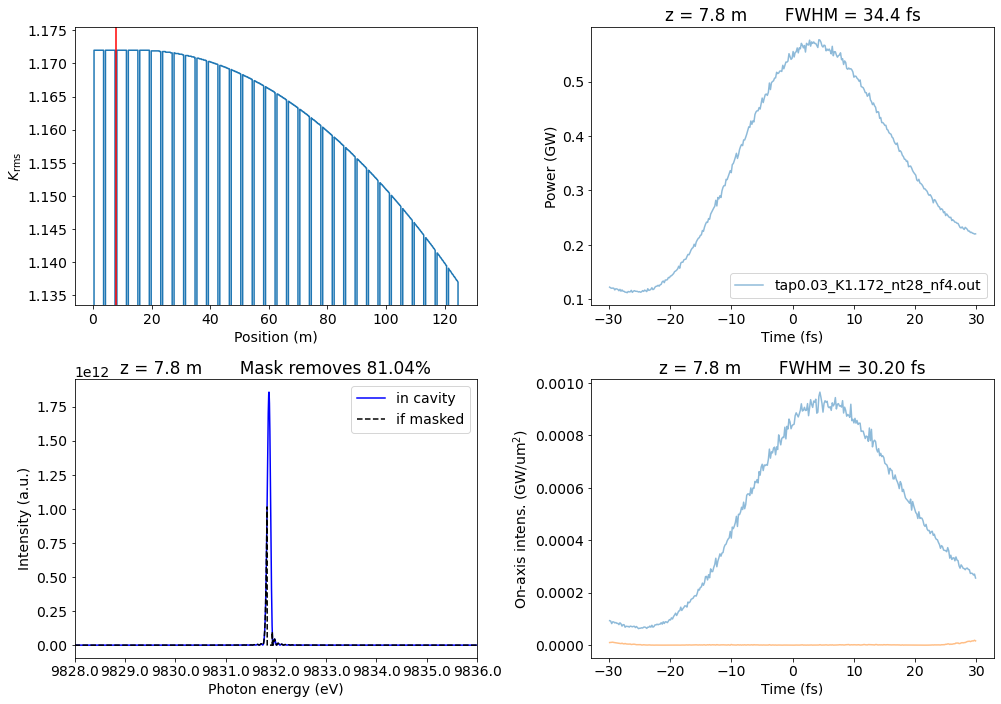

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.86691306666667  fs
Mask removes 53.28 %)
Mask removes 0.05 uJ/um^2 ( 92.37 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  22.19435680000001  fs


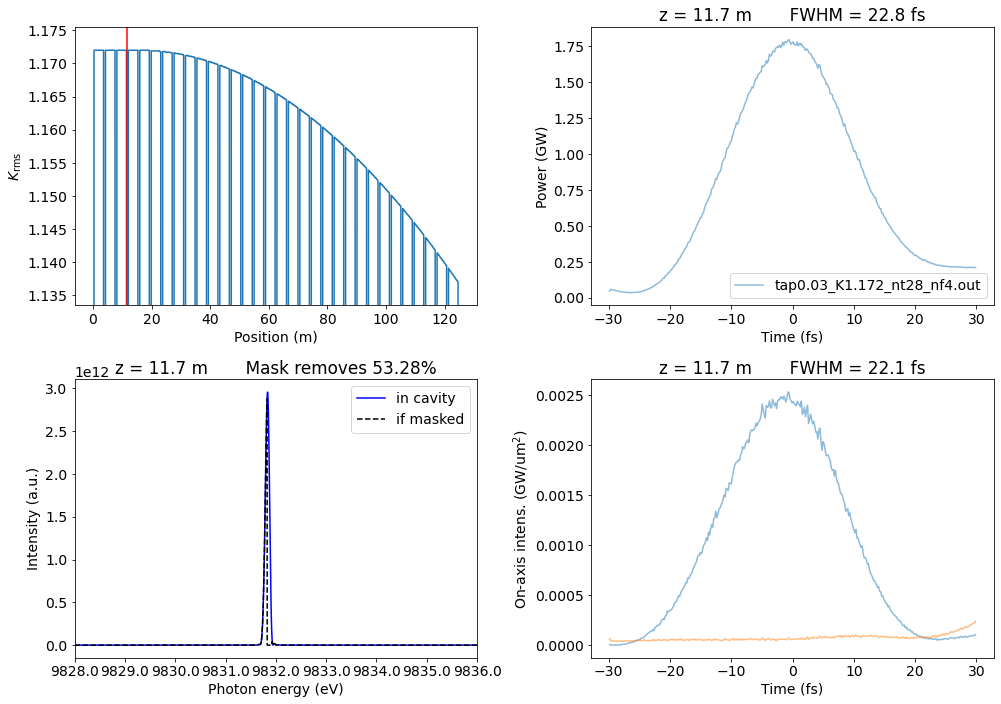

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.6722708  fs
Mask removes 36.91 %)
Mask removes 0.06 uJ/um^2 ( 80.99 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.831575466666674  fs


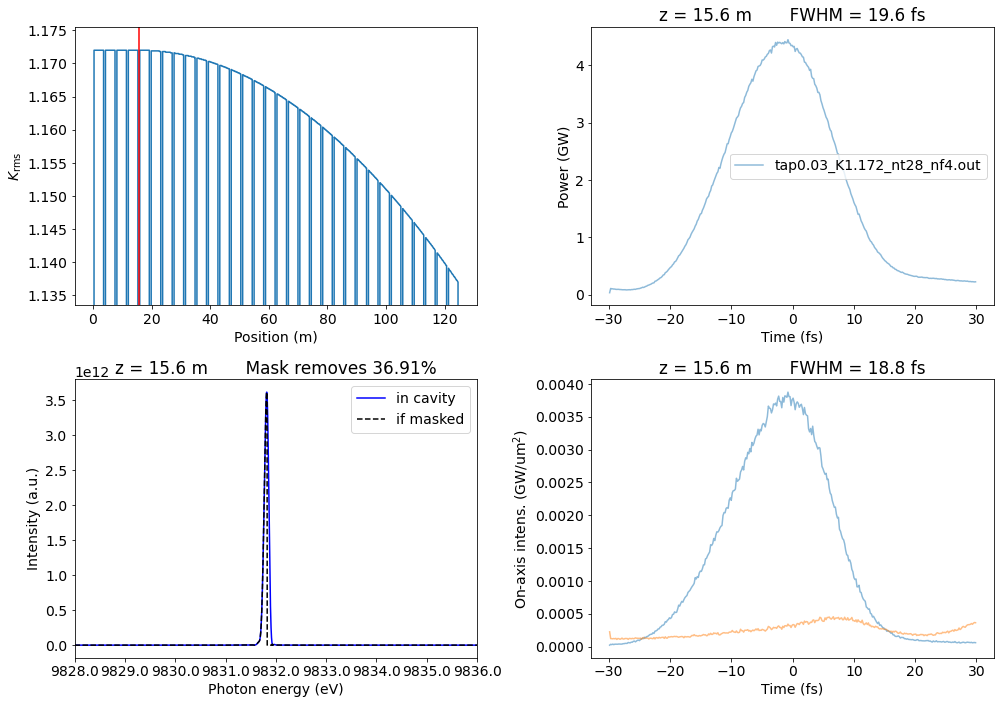

tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs
Mask removes 19.87 %)
Mask removes 0.08 uJ/um^2 ( 61.79 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.654602  fs


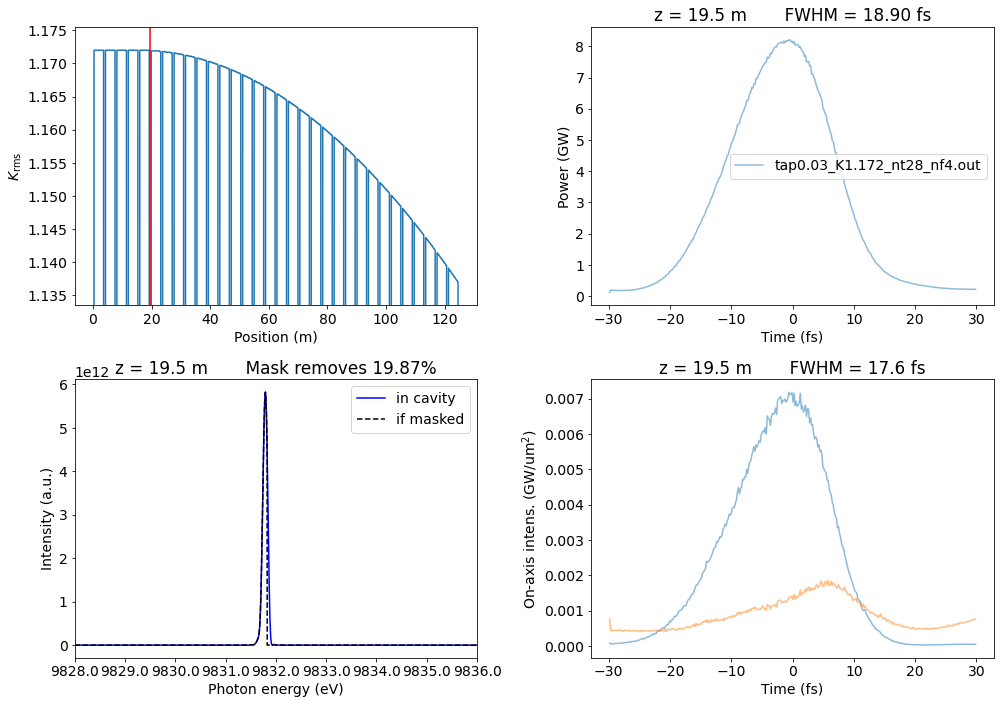

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.1678536  fs
Mask removes 9.49 %)
Mask removes 0.06 uJ/um^2 ( 43.47 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.32715826666667  fs


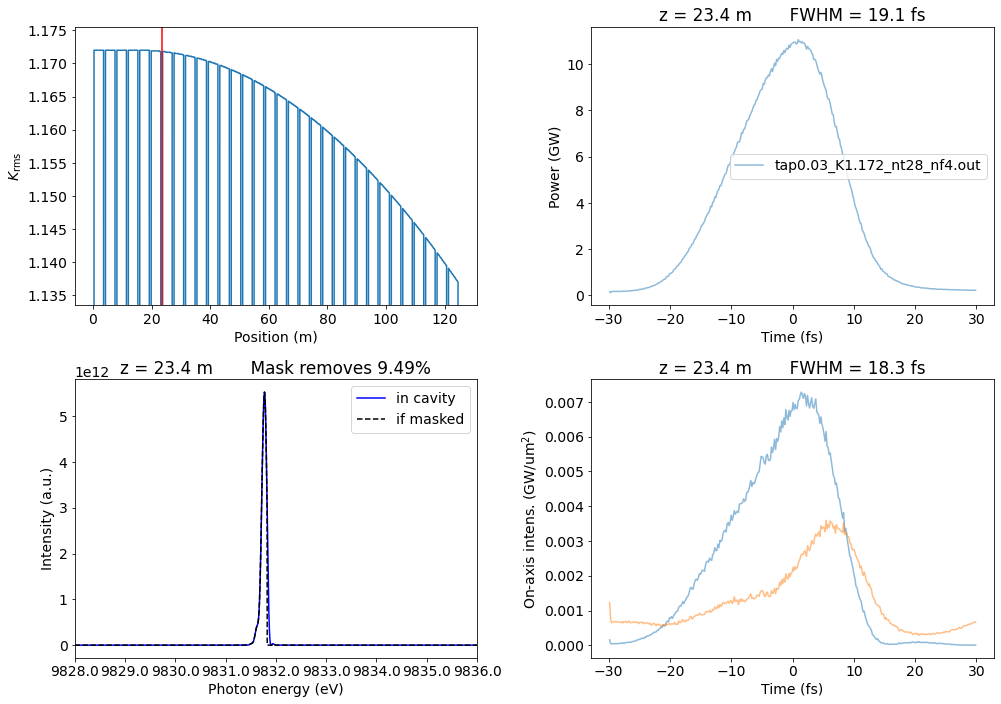

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.33599266666667  fs
Mask removes 3.57 %)
Mask removes 0.03 uJ/um^2 ( 25.82 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  23.035052133333338  fs


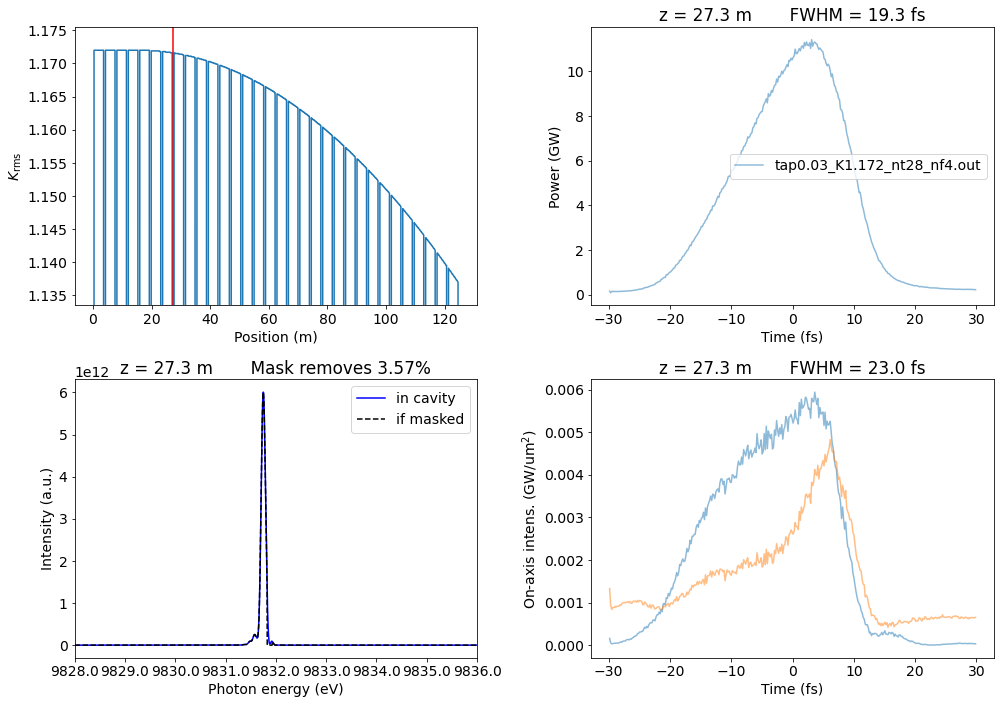

tap0.03_K1.172_nt28_nf4.out FWHM of power  19.84040986666667  fs
Mask removes 5.59 %)
Mask removes 0.03 uJ/um^2 ( 26.68 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  25.22086  fs


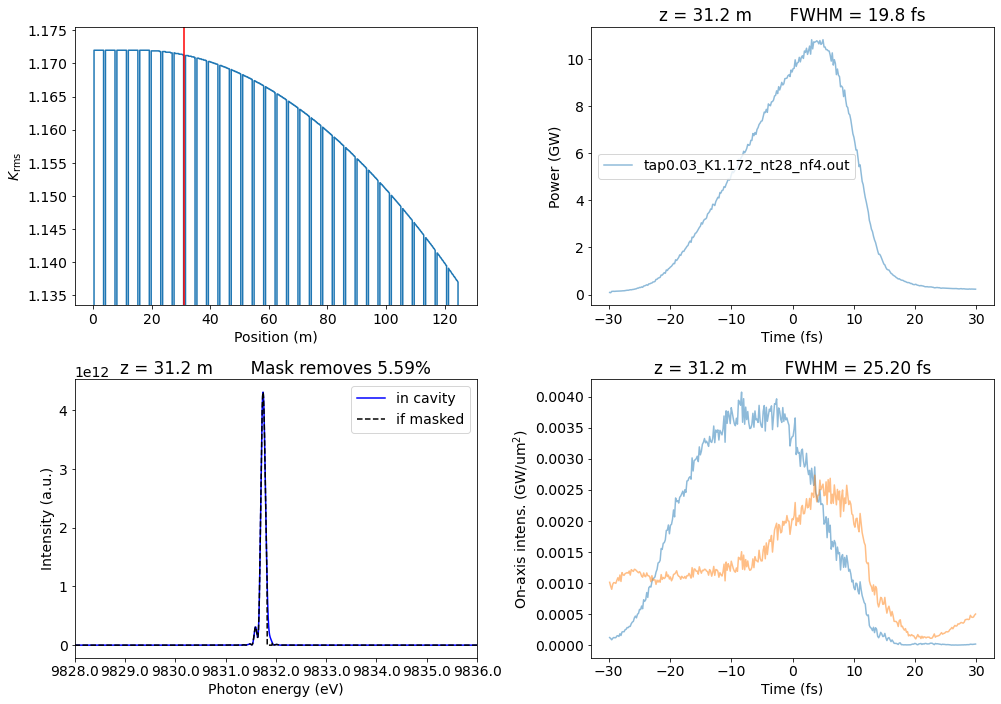

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.026217733333333  fs
Mask removes 4.28 %)
Mask removes 0.03 uJ/um^2 ( 25.13 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  26.229694400000007  fs


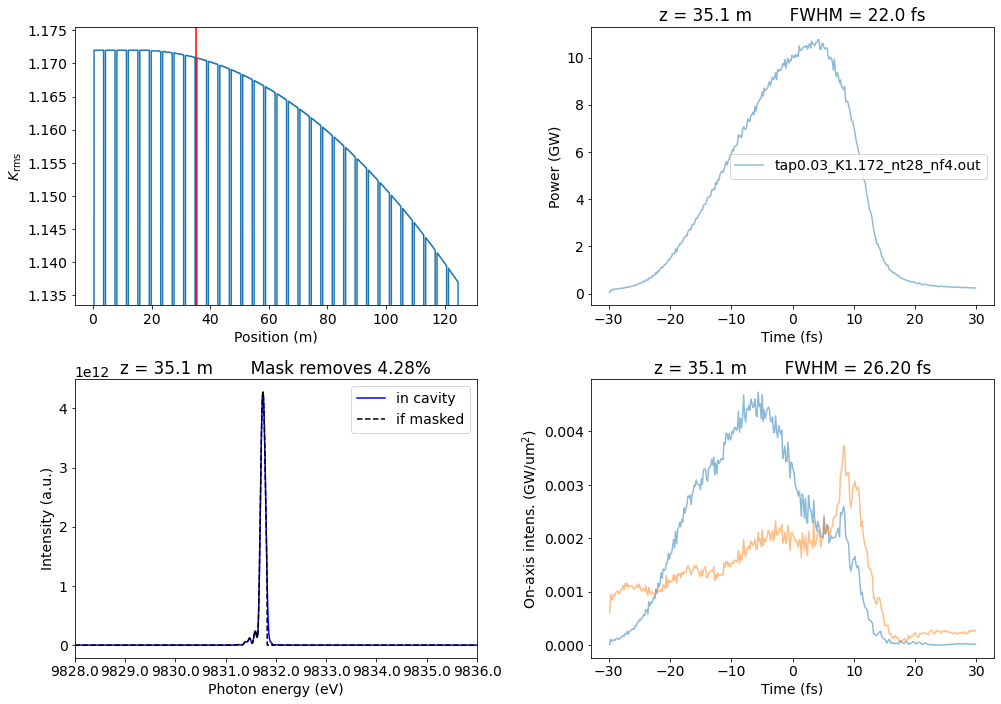

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.043886533333342  fs
Mask removes 4.12 %)
Mask removes 0.03 uJ/um^2 ( 22.07 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.504131733333335  fs


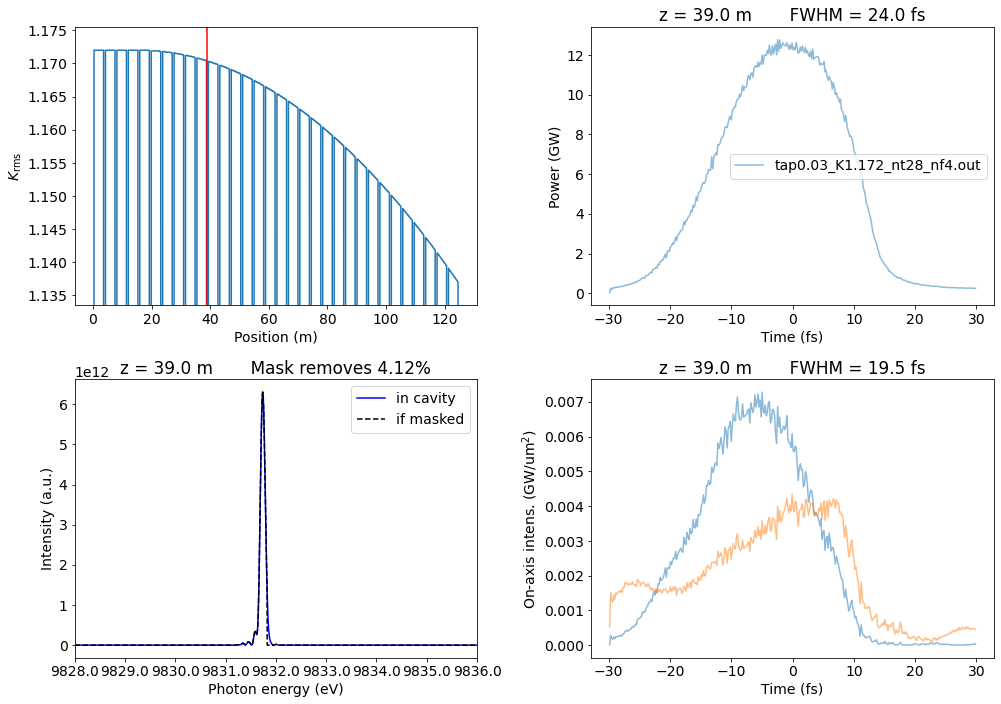

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.2120256  fs
Mask removes 3.76 %)
Mask removes 0.04 uJ/um^2 ( 19.22 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.486462933333332  fs


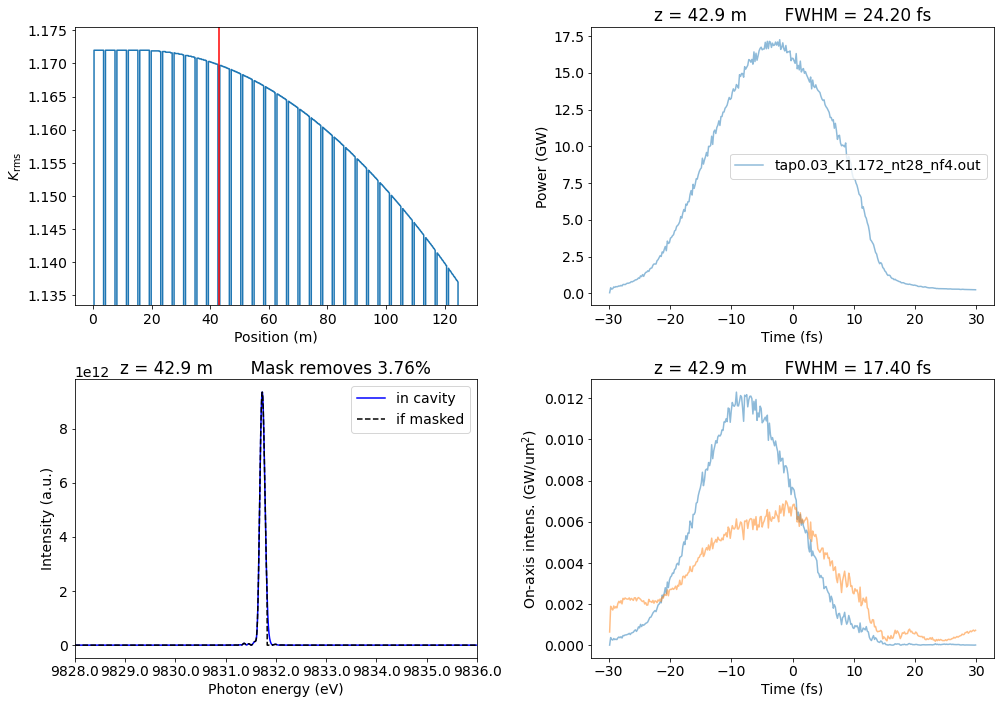

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.043886533333332  fs
Mask removes 3.21 %)
Mask removes 0.05 uJ/um^2 ( 19.93 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.512966133333343  fs


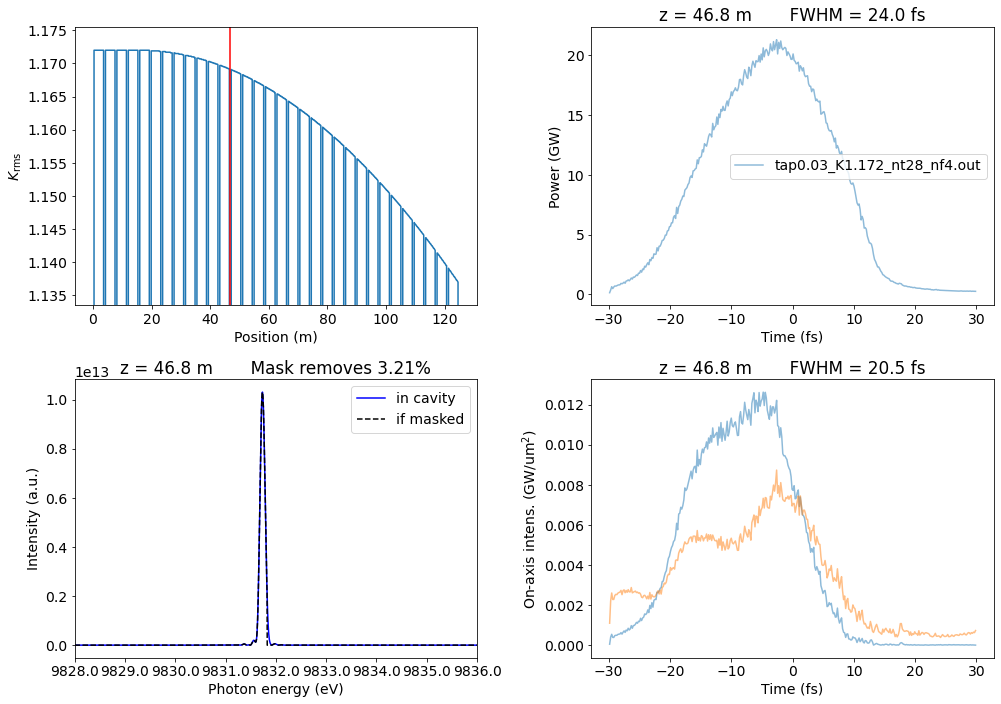

tap0.03_K1.172_nt28_nf4.out FWHM of power  25.220860000000002  fs
Mask removes 3.0 %)
Mask removes 0.04 uJ/um^2 ( 16.38 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666668  fs


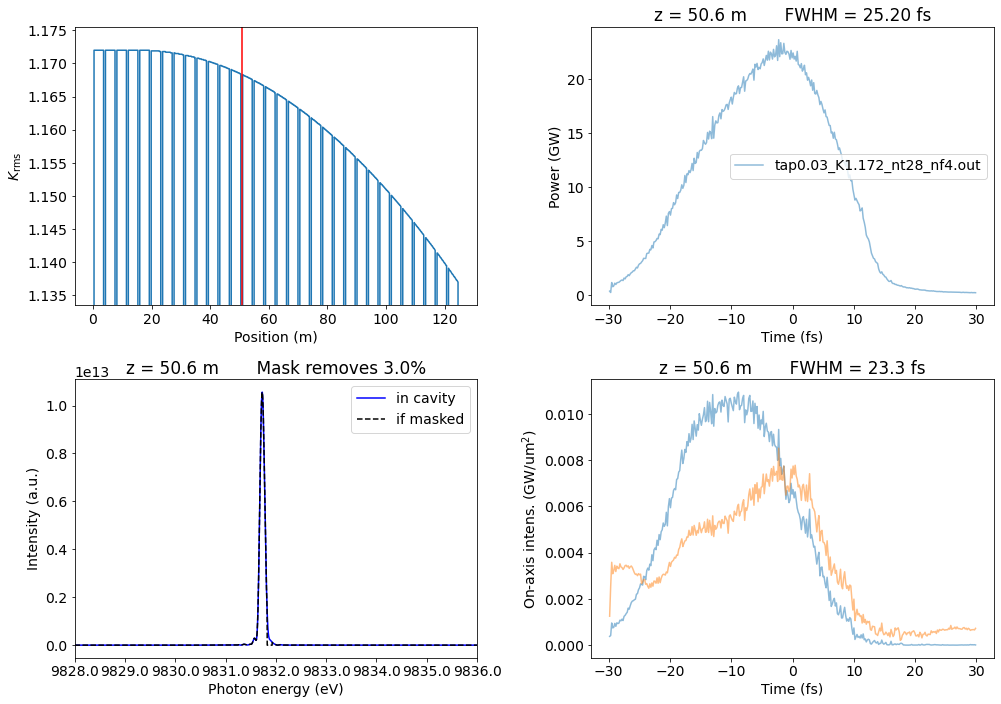

tap0.03_K1.172_nt28_nf4.out FWHM of power  26.061555333333335  fs
Mask removes 5.94 %)
Mask removes 0.06 uJ/um^2 ( 23.19 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  21.017383333333335  fs


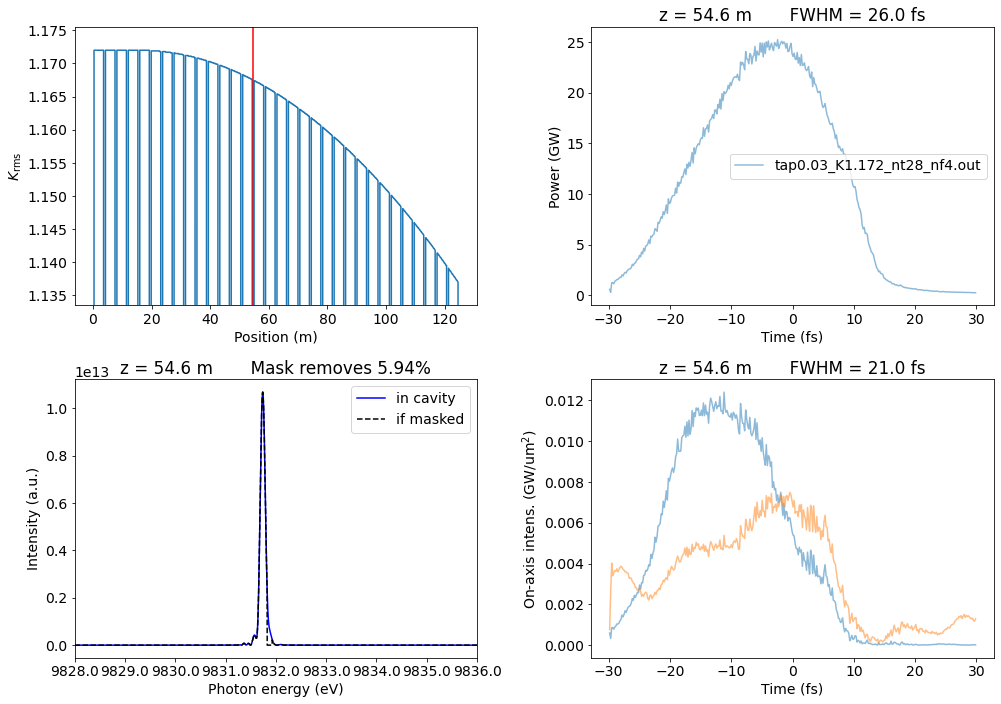

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.716442800000006  fs
Mask removes 7.59 %)
Mask removes 0.09 uJ/um^2 ( 28.57 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.49529733333334  fs


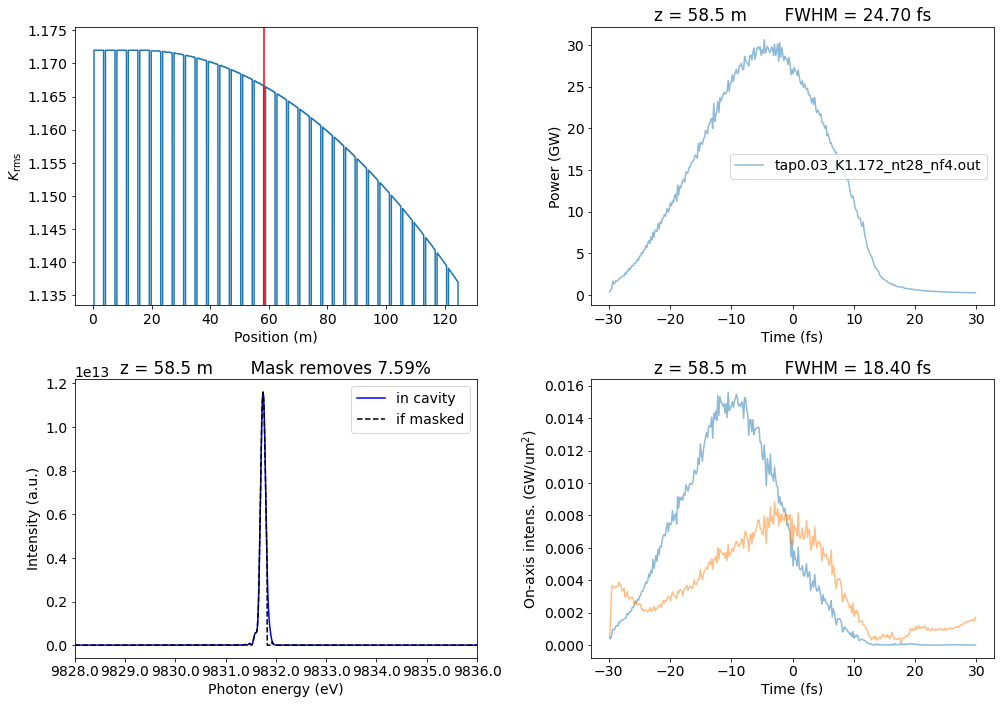

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333333  fs
Mask removes 8.05 %)
Mask removes 0.1 uJ/um^2 ( 28.7 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.6722708  fs


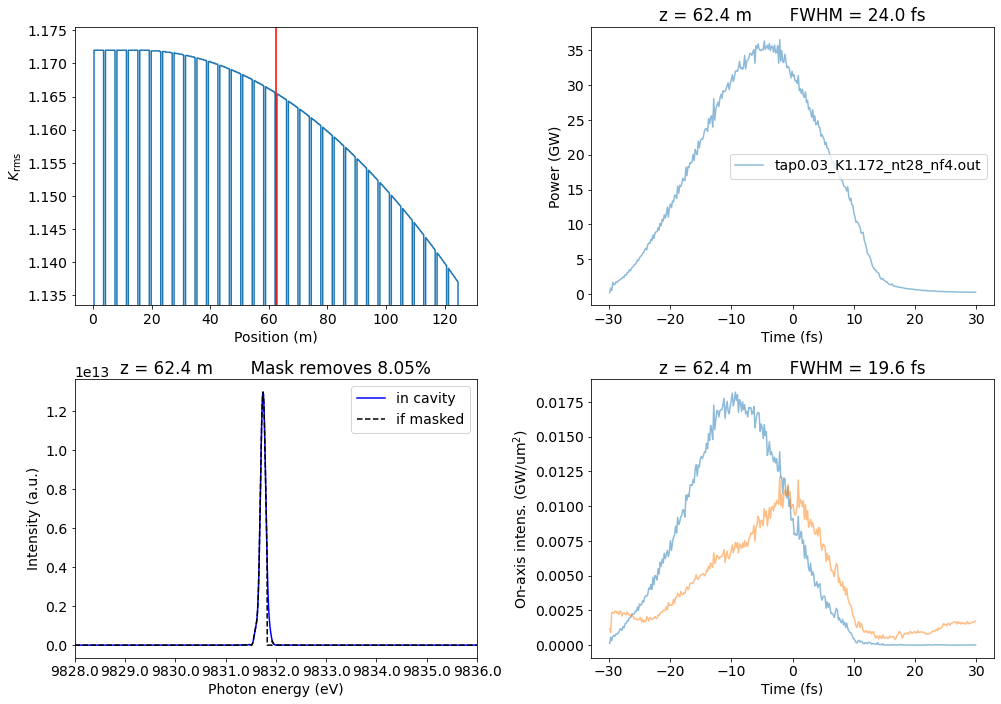

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333334  fs
Mask removes 8.17 %)
Mask removes 0.12 uJ/um^2 ( 26.55 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.512966133333336  fs


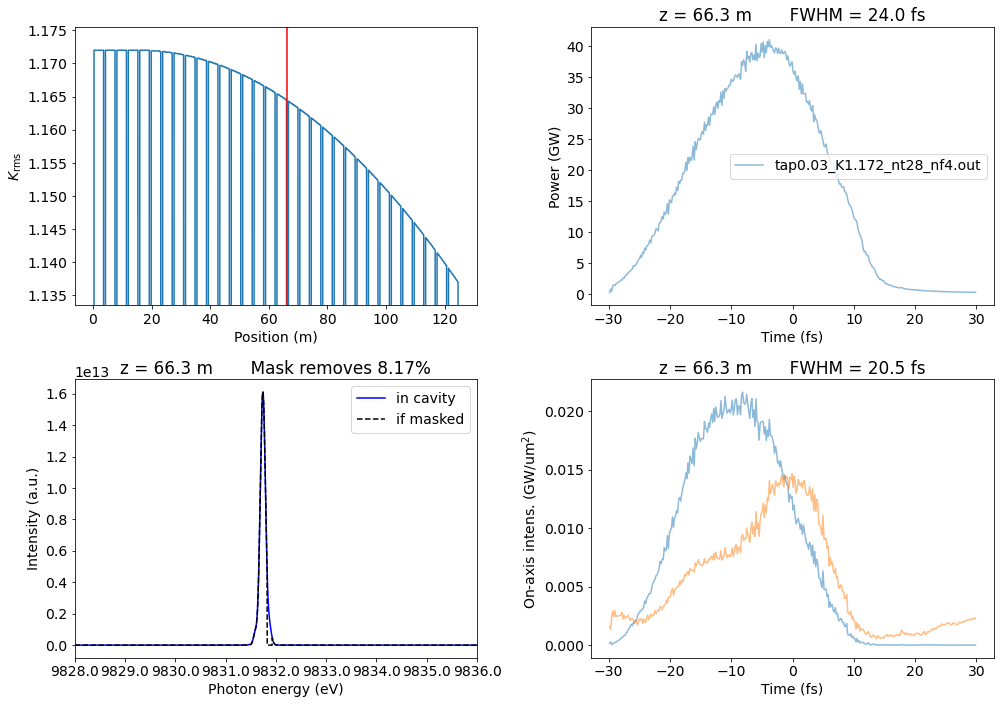

tap0.03_K1.172_nt28_nf4.out FWHM of power  24.04388653333333  fs
Mask removes 8.97 %)
Mask removes 0.15 uJ/um^2 ( 27.78 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.344827066666667  fs


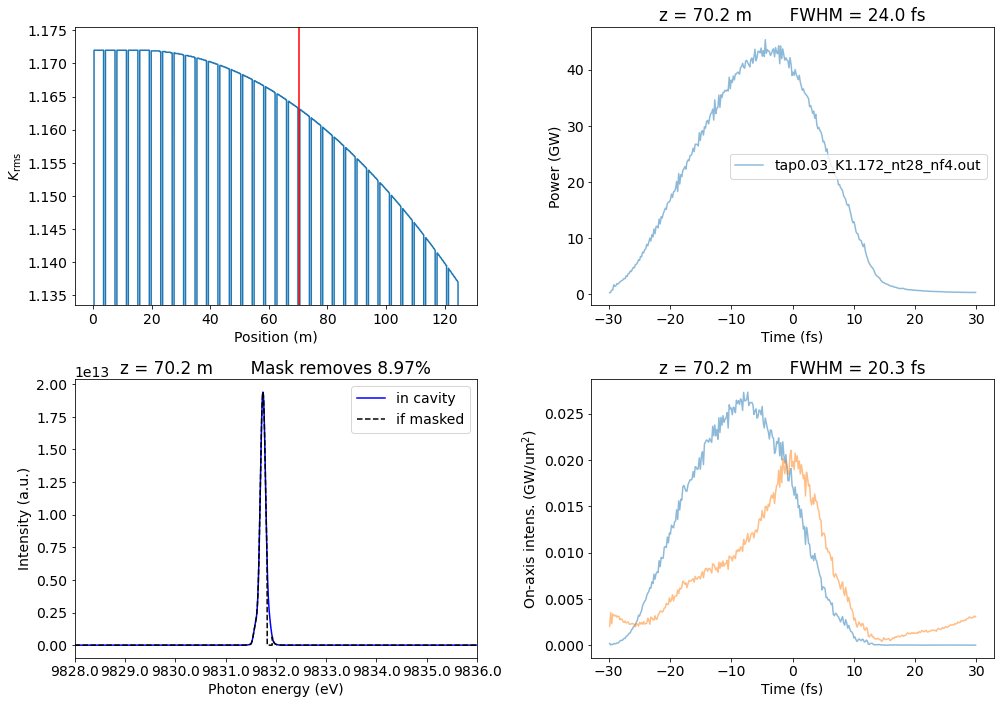

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666664  fs
Mask removes 10.51 %)
Mask removes 0.21 uJ/um^2 ( 30.52 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs


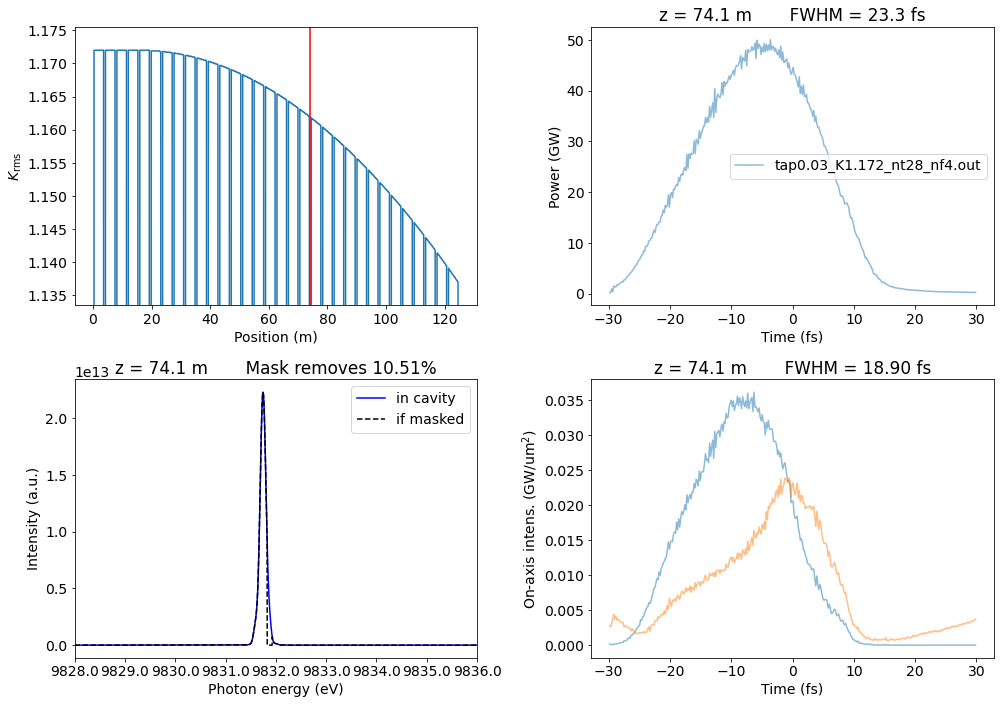

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.03505213333333  fs
Mask removes 10.9 %)
Mask removes 0.23 uJ/um^2 ( 31.15 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.83157546666667  fs


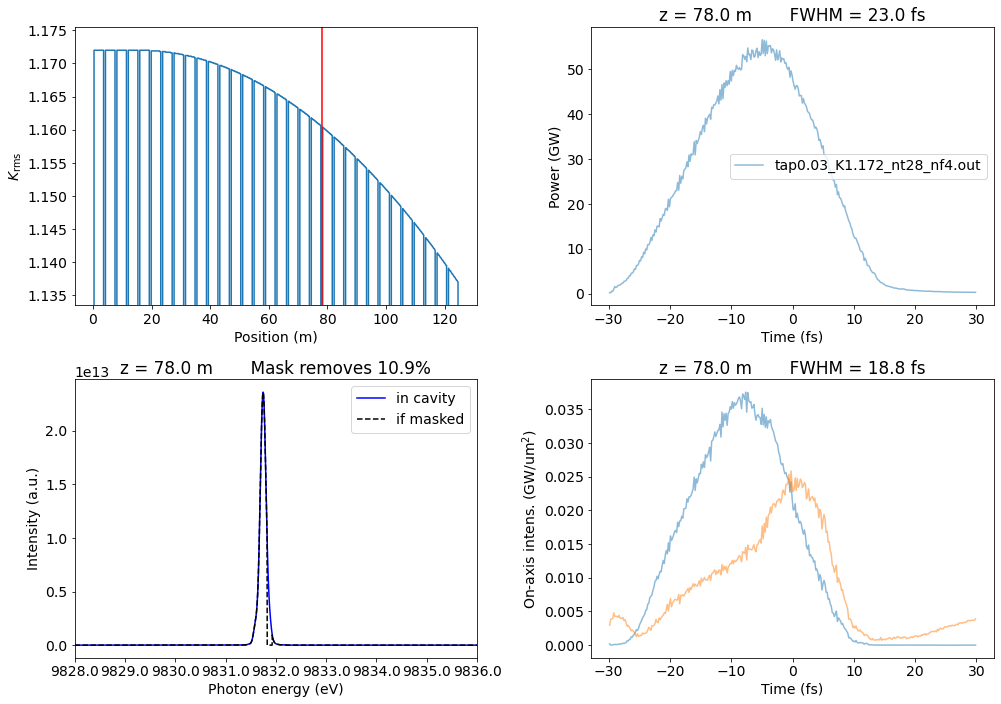

tap0.03_K1.172_nt28_nf4.out FWHM of power  23.371330266666664  fs
Mask removes 10.68 %)
Mask removes 0.23 uJ/um^2 ( 30.06 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.51296613333333  fs


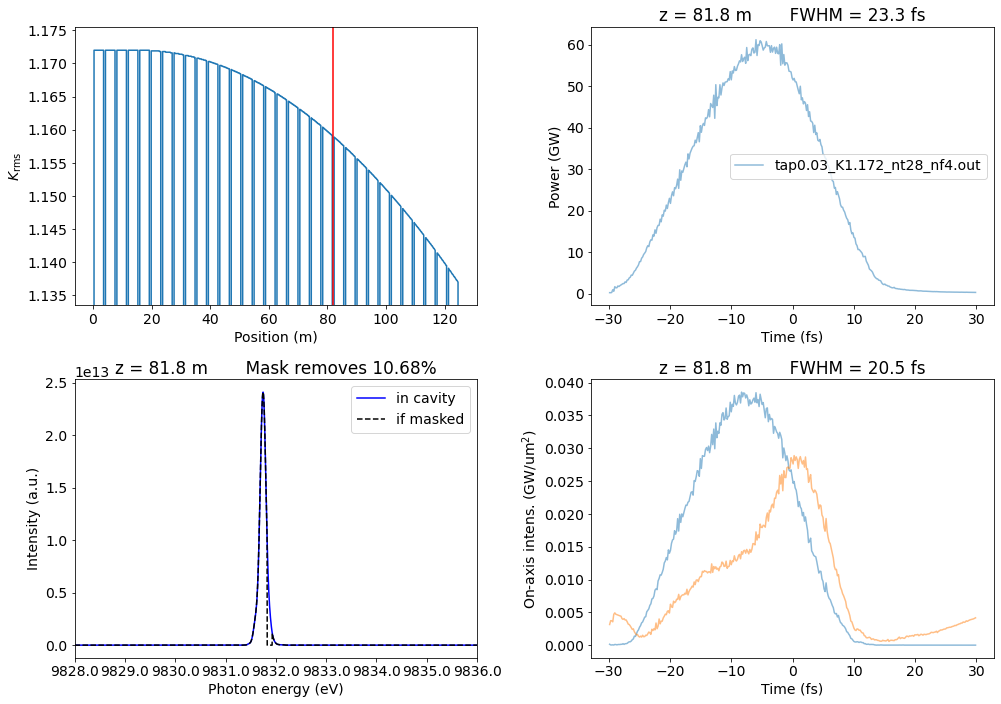

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.866913066666672  fs
Mask removes 11.21 %)
Mask removes 0.24 uJ/um^2 ( 30.99 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.159019200000003  fs


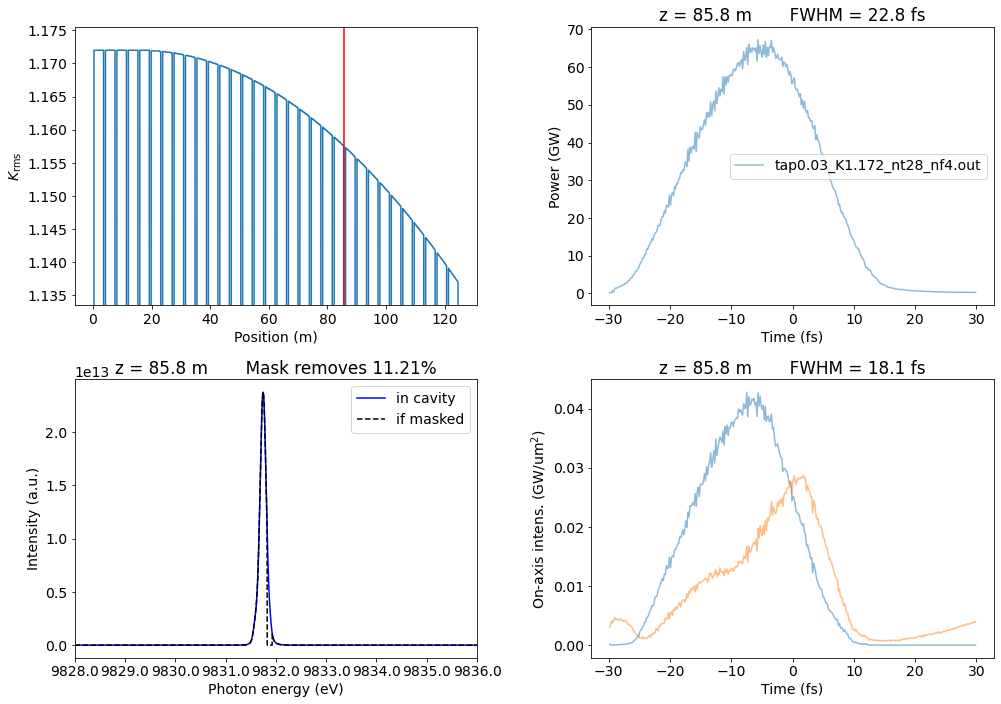

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.698773999999997  fs
Mask removes 11.06 %)
Mask removes 0.24 uJ/um^2 ( 30.88 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  17.31832386666667  fs


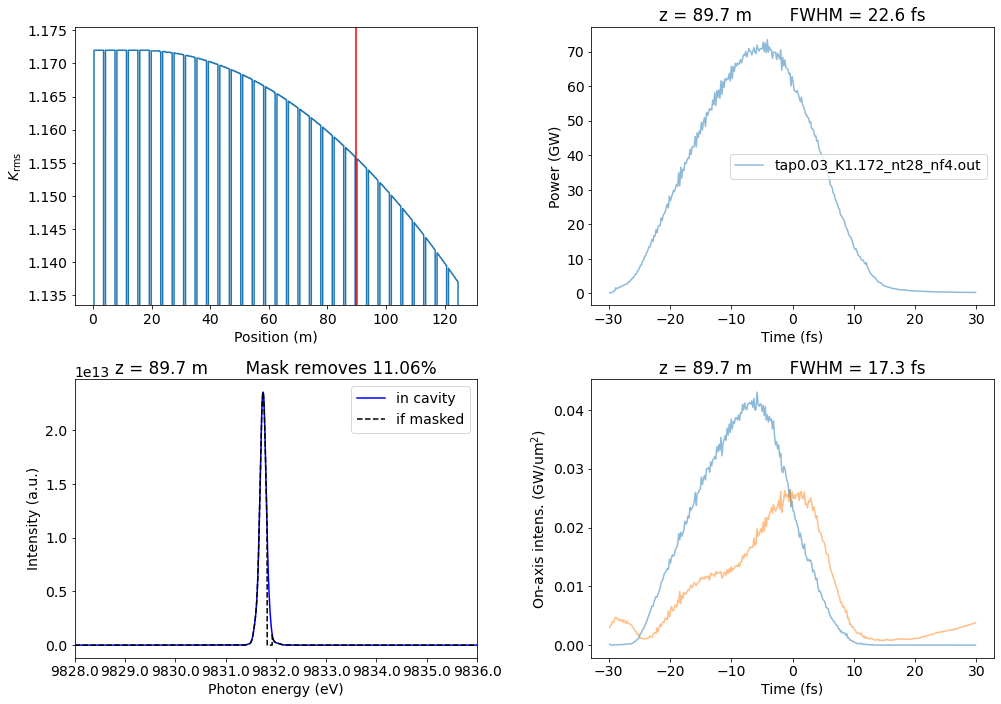

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.530634933333335  fs
Mask removes 11.05 %)
Mask removes 0.23 uJ/um^2 ( 30.15 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.1678536  fs


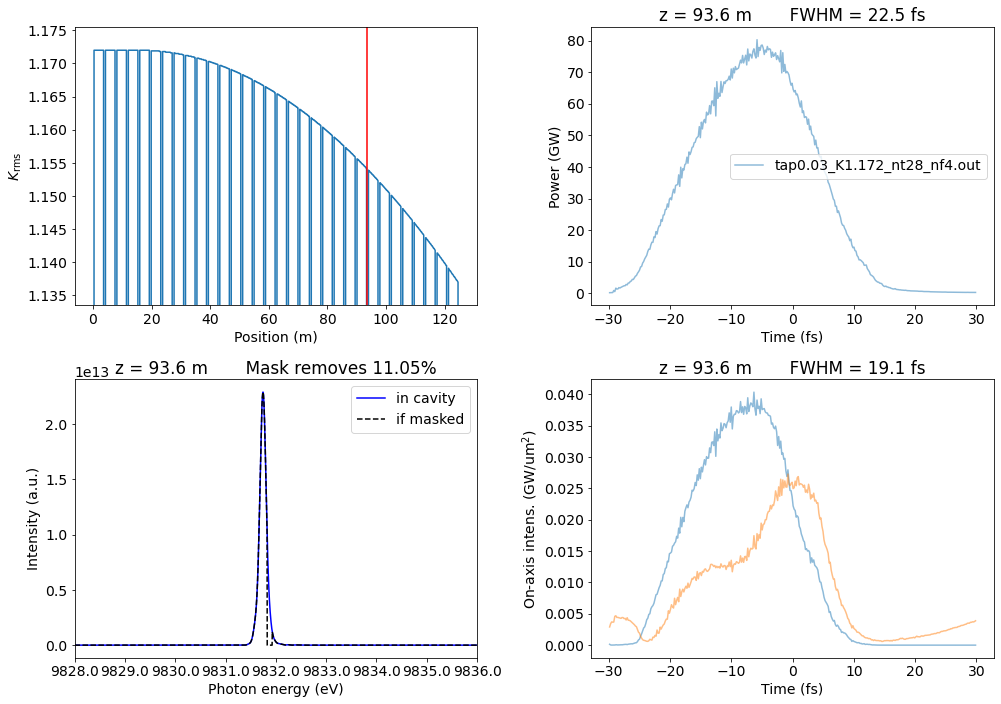

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.53063493333334  fs
Mask removes 11.21 %)
Mask removes 0.23 uJ/um^2 ( 30.4 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.504131733333338  fs


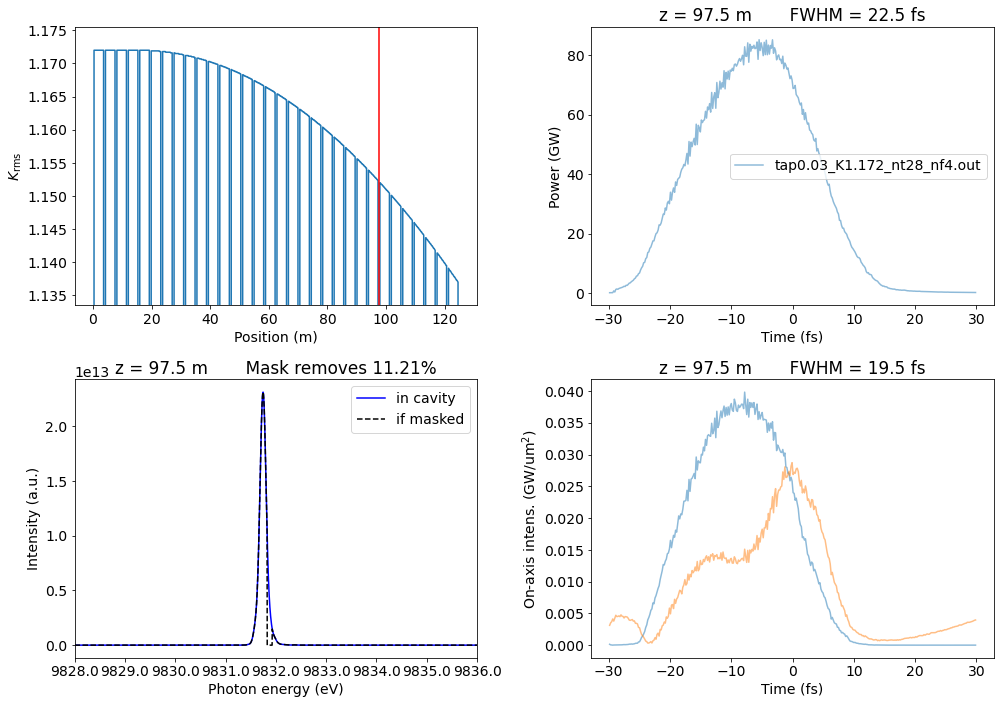

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.530634933333335  fs
Mask removes 12.22 %)
Mask removes 0.23 uJ/um^2 ( 31.37 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.33599266666667  fs


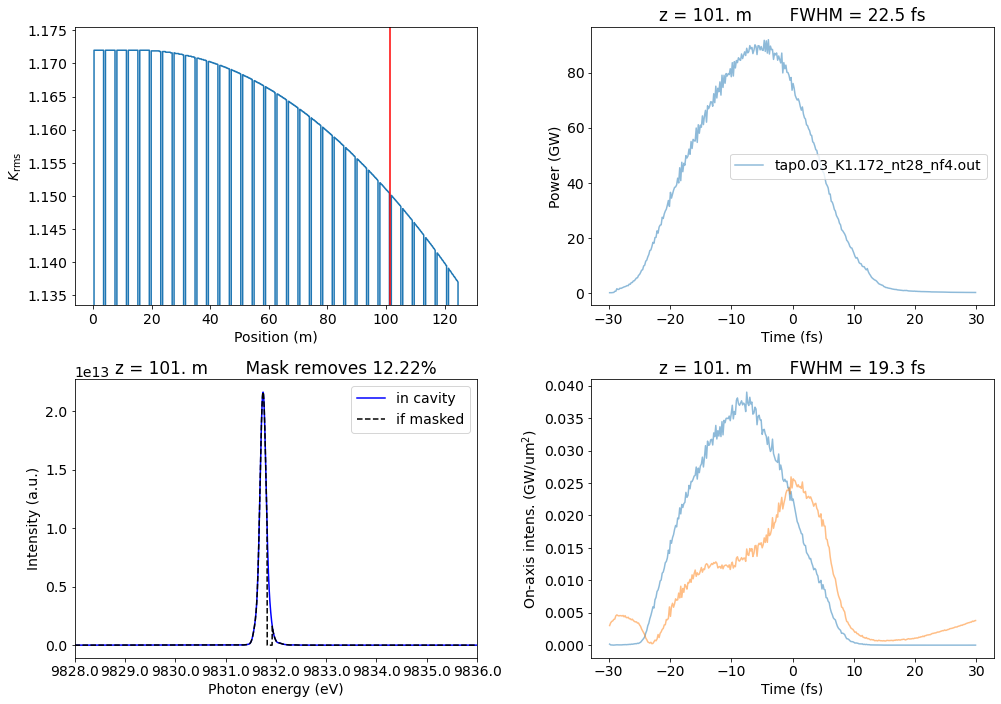

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.858078666666664  fs
Mask removes 12.54 %)
Mask removes 0.24 uJ/um^2 ( 31.06 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  20.008548933333334  fs


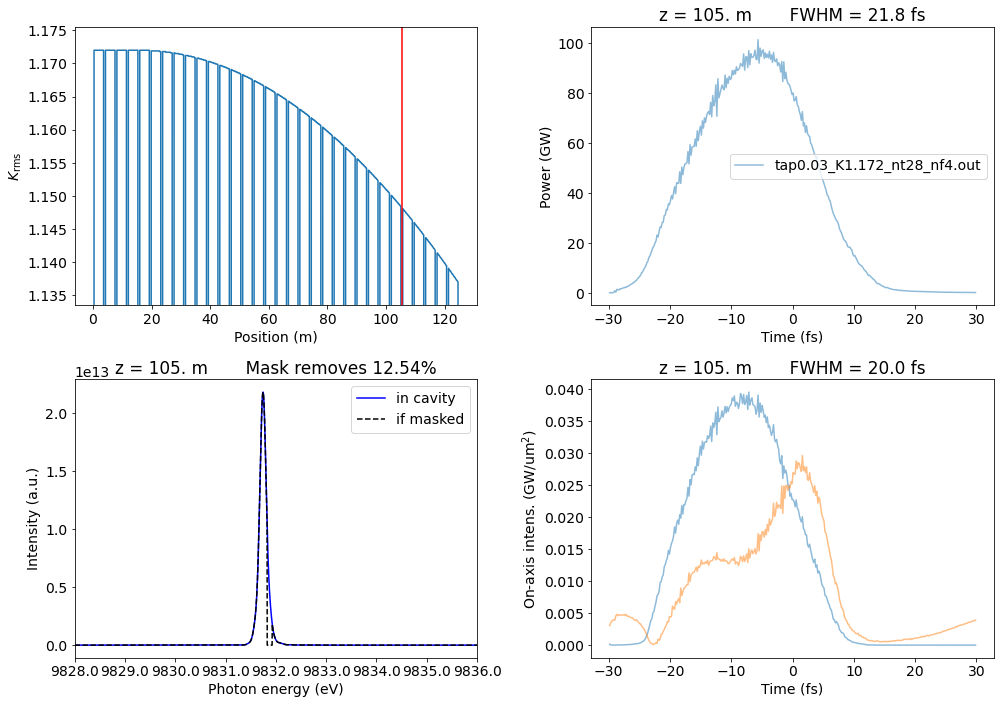

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.194356799999998  fs
Mask removes 12.39 %)
Mask removes 0.24 uJ/um^2 ( 30.48 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.840409866666665  fs


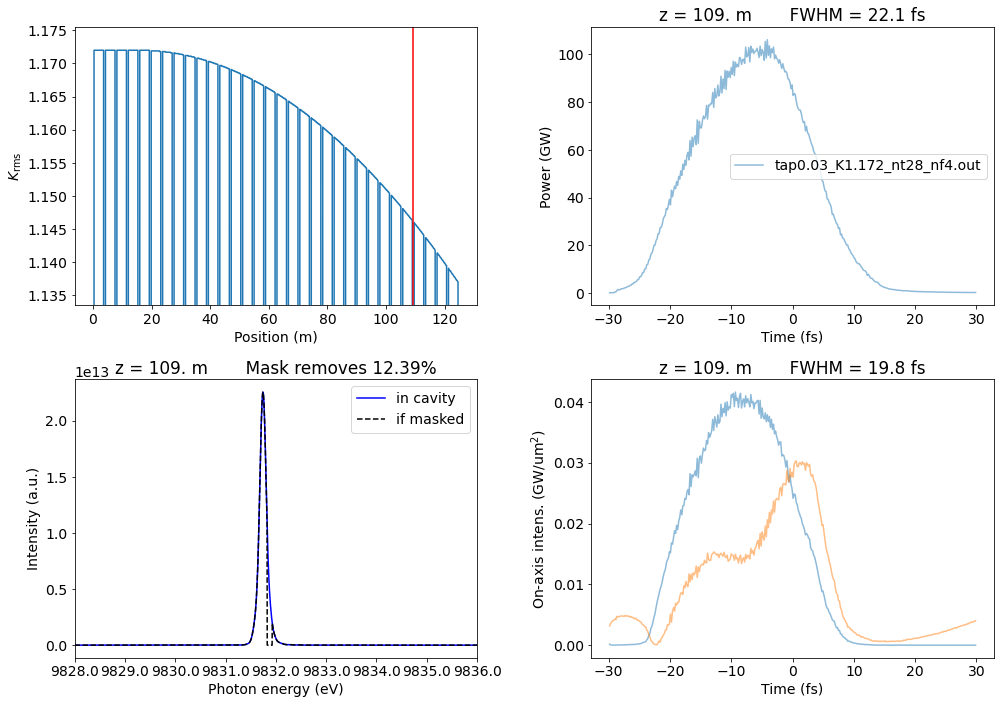

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.36249586666667  fs
Mask removes 12.79 %)
Mask removes 0.27 uJ/um^2 ( 30.92 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.50413173333333  fs


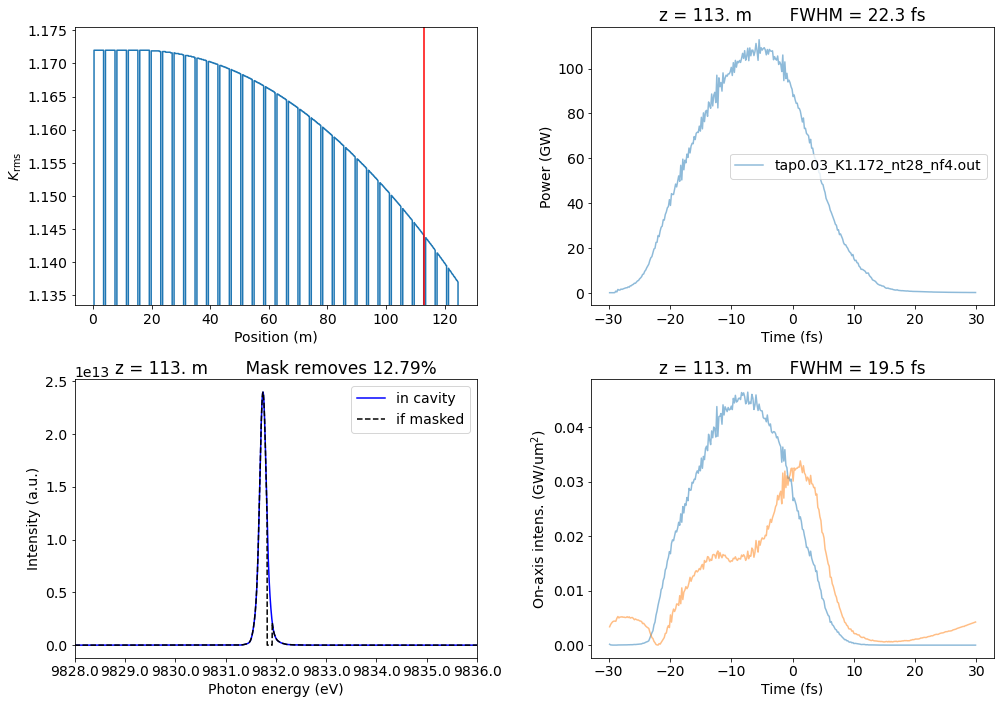

tap0.03_K1.172_nt28_nf4.out FWHM of power  22.026217733333336  fs
Mask removes 13.22 %)
Mask removes 0.3 uJ/um^2 ( 31.4 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.831575466666667  fs


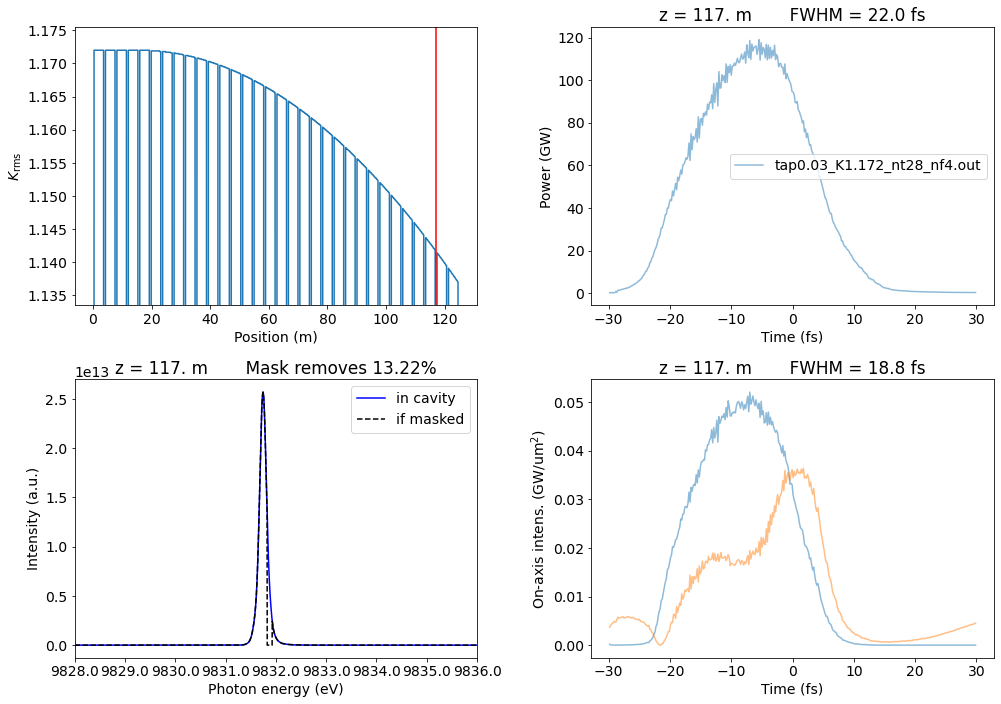

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.858078666666668  fs
Mask removes 13.43 %)
Mask removes 0.31 uJ/um^2 ( 31.61 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  19.167853600000004  fs


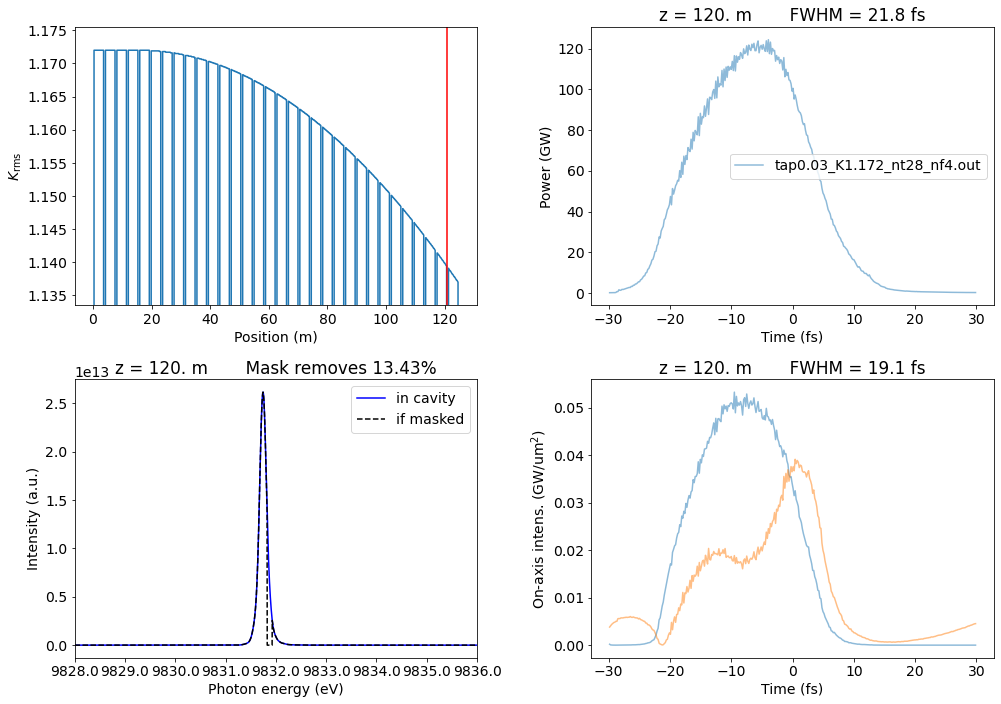

tap0.03_K1.172_nt28_nf4.out FWHM of power  21.521800533333337  fs
Mask removes 13.04 %)
Mask removes 0.3 uJ/um^2 ( 31.09 %)
tap0.03_K1.172_nt28_nf4.out FWHM of power  18.999714533333336  fs


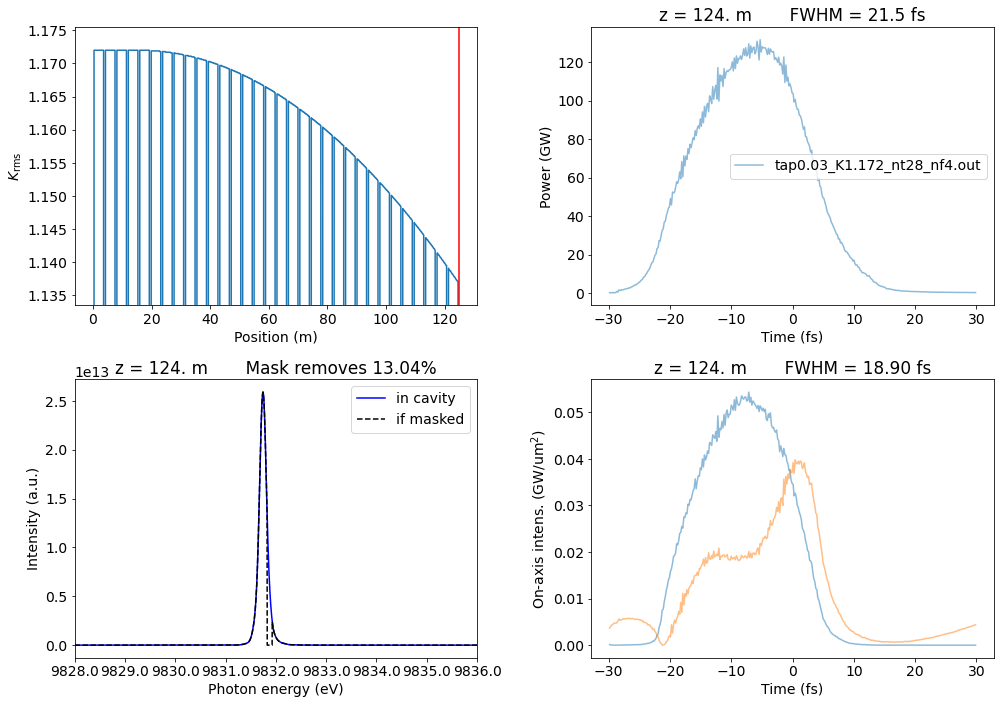

In [26]:
def plot_pow_pmid_spec(z,records,mask_width_eV=200e-3,xlim=None,ylim = None,figsize=(12+2,8+2),animationFrame=False):
    fig = plt.figure(num = 1, figsize=(6,4))
    fig.clf()

    # setup plots
    
    # unds
    ax = plt.subplot(2, 2, 1); plt.sca(ax)
    plotunds(records,legendQ=False,merge_plots=True)
    ylim = plt.ylim()
    plt.plot([z,z],ylim,color='r')
    
    # power
    ax = plt.subplot(2, 2, 2); plt.sca(ax)
    plot_powers(z,records,merge_plots=True)#,figsize=(6,4))
    
    # spectrum
    ax = plt.subplot(2, 2, 3); plt.sca(ax)
    plot_spectra(z,records,merge_plots=True,xlim = [9828,9836])
    
    # pmid
    ax = plt.subplot(2, 2, 4); plt.sca(ax)
    plot_pmid(z,records,merge_plots=True)
    
    plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    plt.tight_layout()
    
    if animationFrame:
        
        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image
        
    else:
        figpath = os.path.join(savefolder,'pow_pmid_spec_z'+str(np.int())+'.png')
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_power_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

        plt.show()
    

Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_pow_pmid_spec(z,records,mask_width_eV=100e-3,xlim=None,ylim = None)

gen_tap0.016_K1.168_n3_t.out FWHM of power  91.46765226666668  fs
Mask removes 90.48 %)
Mask removes 0.05 uJ/um^2 ( 100.0 %)
gen_tap0.016_K1.168_n3_t.out FWHM of power  91.46765226666668  fs
gen_tap0.016_K1.168_n3_t.out FWHM of power  91.46765226666668  fs
Mask removes 90.15 %)
Mask removes 0.04 uJ/um^2 ( 99.78 %)
gen_tap0.016_K1.168_n3_t.out FWHM of power  91.46765226666668  fs
gen_tap0.016_K1.168_n3_t.out FWHM of power  7.061840800000006  fs
Mask removes 75.57 %)
Mask removes 0.02 uJ/um^2 ( 85.87 %)
gen_tap0.016_K1.168_n3_t.out FWHM of power  4.371615733333332  fs
gen_tap0.016_K1.168_n3_t.out FWHM of power  5.464519666666664  fs
Mask removes 34.1 %)
Mask removes 0.01 uJ/um^2 ( 41.73 %)
gen_tap0.016_K1.168_n3_t.out FWHM of power  4.45568526666667  fs
gen_tap0.016_K1.168_n3_t.out FWHM of power  4.960102466666669  fs
Mask removes 10.93 %)
Mask removes 0.01 uJ/um^2 ( 15.16 %)
gen_tap0.016_K1.168_n3_t.out FWHM of power  4.7919633999999895  fs
gen_tap0.016_K1.168_n3_t.out FWHM of power  4.

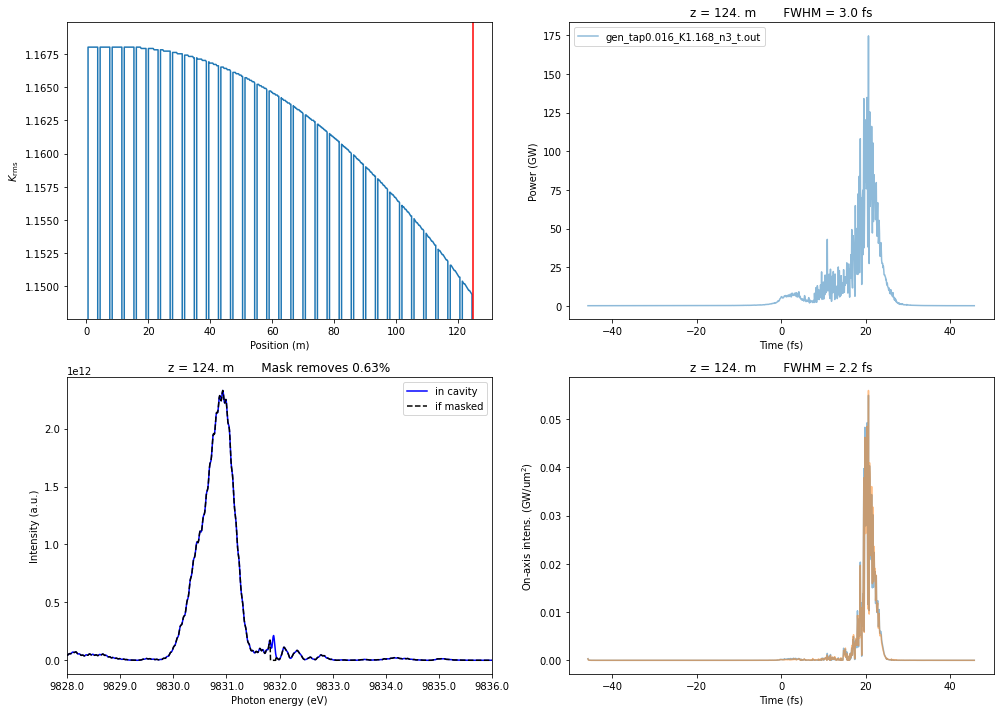

In [47]:
# https://ndres.me/post/matplotlib-animated-gifs-easily/
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

Lund = 3.9
nund = np.int(max(zlist)/Lund)
frames = [plot_pow_pmid_spec(z,records,mask_width_eV=200e-3,xlim=None,ylim=None,animationFrame=True) for z in np.arange(nund+1)*Lund]
for i in range(5):
    frames += [frames[-1]]

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
figpath = os.path.join(savefolder,'pow_pmid_spec_vs_z.gif')
imageio.mimsave(figpath, frames, fps=0.5)

In [27]:
def plot_power_bandwith_vs_z(statfcn=[fwhm,mwhm,rms][0],color = 'C2'):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    mp = np.mean(pows_vs_z, axis=0)
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,color = 'C1', linestyle='dashed',label = files[count-1].split('/')[-1])
    
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)',color = 'C1')
    
    ax = plt.gca()
    
    tax = ax.twinx()
    
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        tax.plot(zlist,p,alpha=0.2)
    tax.plot(zlist,mp,color=color)
    
    tax.set_ylabel('FWHM Bandwith(eV)', color = 'g')
    #tax.set_ylim([0.08,0.2])

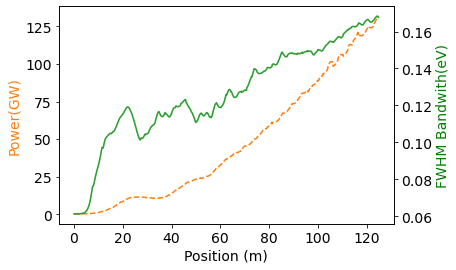

In [28]:
plot_power_bandwith_vs_z()

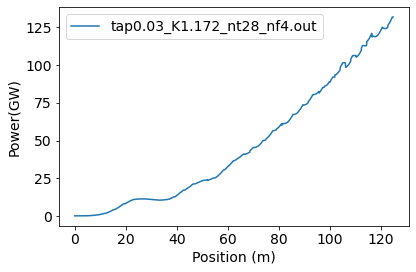

Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.33 %)
Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.34 %)
Mask removes 88.35 %)
Mask removes 88.35 %)
Mask removes 88.37 %)
Mask removes 88.38 %)
Mask removes 88.39 %)
Mask removes 88.41 %)
Mask removes 88.43 %)
Mask removes 88.45 %)
Mask removes 88.47 %)
Mask removes 88.5 %)
Mask removes 88.52 %)
Mask removes 88.55 %)
Mask removes 88.59 %)
Mask removes 88.62 %)
Mask removes 88.62 %)
Mask removes 88.63 %)
Mask removes 88.63 %)
Mask removes 88.64 %)
Mask removes 88.68 %)
Mask removes 88.72 %)
Mask removes 88.76 %)
Mask removes 88.8 %)
Mask removes 88.82 %)
Mask removes 88.84 %)
Mask removes 88.84 %)
Mask removes 88.82 %)
Mask removes 88.79 %)
Mask removes 88.73 %)
Mask removes 88.64 %)
Mask removes 88.53 %)
Mask removes

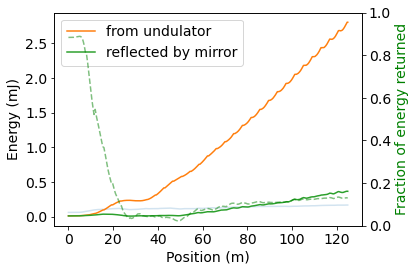

No handles with labels found to put in legend.


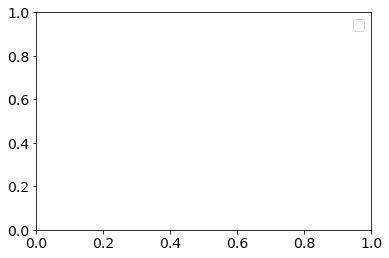

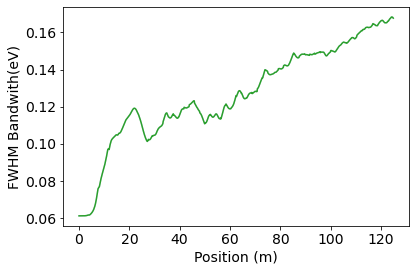

In [29]:
def plot_peak_powers_vs_z(color='C2',xlim=None,ylim=None,statfcn=[fwhm,mwhm,rms][0],merge_plots=False):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    mp = np.mean(pows_vs_z, axis=0)
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,label = files[count-1].split('/')[-1])
    #plt.plot(zlist,mp,color=color,label='Power (GW)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)')
    plt.legend()
    plt.tight_layout()
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_powervsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        plt.plot(zlist,p,alpha=0.2)

def plot_pulse_energies_vs_z(color='C0',xlim=None,ylim=None,merge_plots=False):
    pows_vs_z = []
    frac_pow_vs_z = []
    rpows_vs_z = []
    for z in zlist:
        pows_at_z = []
        rpows_at_z = []
        frac_pow_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.sum(pl)*(sl[1]-sl[0])]
            hws, spectra, mask, netrm, pctrm =get_spectra(z, rec, mask_width_eV=100e-3)
            rpows_at_z += [np.sum(pl)*(sl[1]-sl[0])*pctrm/100]
            frac_pow_at_z += [pctrm/100]
        pows_vs_z += [pows_at_z]
        rpows_vs_z += [rpows_at_z]
        frac_pow_vs_z += [frac_pow_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e3
    rpows_vs_z = np.transpose(rpows_vs_z)*1e3
    frac_pow_vs_z = np.transpose(frac_pow_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    count = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p, label = 'from undulator')
    count = 0
    for pr in rpows_vs_z:
        count += 1
        plt.plot(zlist,pr, label = 'reflected by mirror')
    ax = plt.gca()
    ax.set_xlabel('Position (m)')
    ax.set_ylabel('Energy (mJ)')
    plt.legend()
    tax = ax.twinx()
    for fpr in frac_pow_vs_z:
        tax.plot(zlist, fpr,'g--', alpha = 0.5)
    tax.set_ylabel('Fraction of energy returned', color = 'g')
    tax.set_ylim([0,1])
    #plt.plot(zlist,mp,color=color,label='Energy (mJ)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    
    plt.tight_layout()
    
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_pulseenergyvsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

def plot_relative_bandwidth_vs_z(color='C1',xlim=None,ylim=None,statfcn=[fwhm,mwhm,rms][1],merge_plots=False):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        plt.plot(zlist,p,alpha=0.2)
    plt.plot(zlist,mp,color=color)
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('Position (m)')
    plt.ylabel('FWHM Bandwith(eV)')
    plt.tight_layout()
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_bwvsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

plot_peak_powers_vs_z(merge_plots=False)
plot_pulse_energies_vs_z(merge_plots=False)
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=fwhm,color='C1') #comment out
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=mwhm,color='C2') # any of these
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=rms,color='C3') # to customize
#plt.ylim([0,1.]); 
plt.legend()
plt.savefig(savefolder+'/'+fnhead+'_bwandenergyvs_many.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()

#plot_peak_powers_vs_z(merge_plots=True)
#plot_pulse_energies_vs_z(merge_plots=True)
# plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=fwhm,color='C1') #comment out
plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=mwhm,color='C2') # any of these
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=rms,color='C3') # to customize
#plt.ylim([0,1.]); plt.legend()
#plt.savefig(savefolder+'/'+fnhead+'_bwandenergyvs_many.png', bbox_inches='tight')
#if showPlotQ: plt.show(); 
#plt.close()

In [60]:

#     if useMask:
#         ax1.plot(hws, spectra, label='unmasked', **marker_style)
#         ax1.plot(hws, mask * spectra, label='masked', **marker_style)
#         ax1.legend()
#     else:
#         ax1.plot(hws, spectra, **marker_style)
        
#     ax1.set_xlabel('Photon energy (eV)', fontsize = fontsize)
#     #ax1.set_ylabel(r'Spectral intensity (uJ/eV)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
#     ax1.set_ylabel('On-axis spectral fluence\n(uJ/um$^2$/eV)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
#     # display figure
#     plt.tight_layout()
#     plt.savefig(savefolder+'/'+fnhead+'_output_spectra.png', bbox_inches='tight')
#     if showPlotQ: plt.show(); 
#     plt.close()

Text(0, 0.5, 'Energy (MeV)')

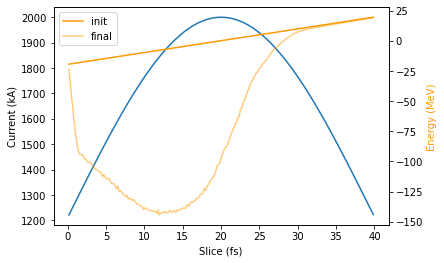

In [14]:
fig, ax = plt.subplots()
slist_fs, currlist = getmeanovers('currlist')
ax.plot(slist_fs, currlist)
ax.set_xlabel('Slice (fs)')
ax.set_ylabel('Current (kA)')
axr = ax.twinx()
slist_fs, energylist_init = getmeanovers('energylist_init')
axr.plot(slist_fs, energylist_init, '#ff9900', label='init')
slist_fs, energylist_fin = getmeanovers('energylist_fin')
axr.plot(slist_fs, energylist_fin, '#ff9900', alpha=0.5, label='final')
axr.legend()
axr.set_ylabel('Energy (MeV)', color = '#ff9900')

ValueError: num must be 1 <= num <= 16, not 17

/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/matplotlib/image.py:489: RuntimeWarning: overflow encountered in true_divide
  vrange /= ((a_max - a_min) / frac)
/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


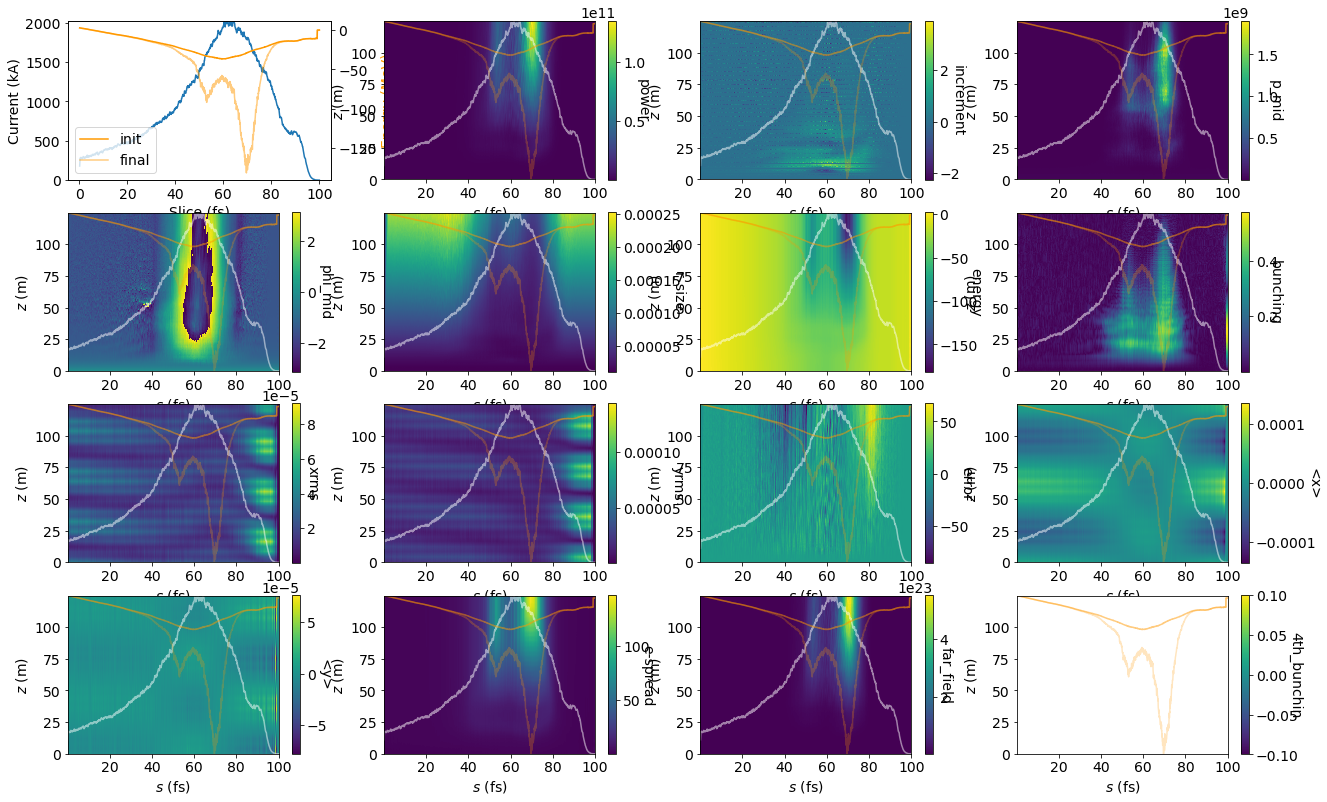

In [293]:

#########################################
# plot properties for z vs slice for various zs

# setup figure
#fig = plt.figure(num = 1, figsize = 3.375 * np.array([1.61 * 3, 1]))
fig = plt.figure(num = 1, figsize = 3.375 * np.array([1.61 * 4, 4]))
fig.clf()
marker_style = dict(marker = '',
        linewidth = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
e_style = dict(marker = '.', linestyle = '',
        markersize = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')

# setup plots
ax = plt.subplot(4, 4, 1)
slist_fs, currlist = getmeanovers('currlist')
ax.plot(slist_fs, currlist)
ax.set_xlabel('Slice (fs)')
ax.set_ylabel('Current (kA)')
ax.set_ylim(0, np.max(currlist))
axr = ax.twinx()
slist_fs, energylist_init = getmeanovers('energylist_init')
axr.plot(slist_fs, energylist_init, '#ff9900', label='init')
slist_fs, energylist_fin = getmeanovers('energylist_fin')
axr.plot(slist_fs, energylist_fin, '#ff9900', alpha=0.5, label='final')
axr.legend()
axr.set_ylabel('Energy (MeV)', color = '#ff9900')
currlist_scaled = currlist - 0*np.min(currlist); currlist_scaled /= np.max(currlist_scaled); currlist_scaled *= np.max(zlist) - np.min(zlist); currlist_scaled += np.min(zlist)
energylist_init_scaled = energylist_init - np.min(energylist_fin); energylist_init_scaled /= np.max(energylist_init_scaled); energylist_init_scaled *= np.max(zlist) - np.min(zlist); energylist_init_scaled += np.min(zlist)
energylist_fin_scaled = energylist_fin - np.min(energylist_fin); energylist_fin_scaled /= np.max(energylist_fin_scaled); energylist_fin_scaled *= np.max(zlist) - np.min(zlist); energylist_fin_scaled += np.min(zlist)
# NOTE: havent averaged over ipseeds in this loop yet
for ia in np.arange(3,outputdat.shape[1]):
    ax = plt.subplot(4, 4, ia - 2 + 1)
    #ax_r = ax.twinx()
    pdat = np.reshape(np.array(outputdat.iloc[:,ia]), [int(outputdat.shape[0] / len(zlist)), len(zlist)]).T
    im = ax.imshow(pdat, interpolation = 'none', extent = [slist_fs[0], slist_fs[-1], zlist[0], zlist[-1]], origin = 'lower', aspect = 0.75*(slist_fs[-1] - slist_fs[0]) / (zlist[-1] - zlist[0]))
    ax.set_xlabel('$s$ (fs)')
    ax.set_ylabel('$z$ (m)')
    #ax_r.set_ylabel('Dashed line: current (kA)')
    #ax.set_title(outputdat.keys()[ia])
    cbar = fig.colorbar(im, ax = ax)
    cbar.set_label(outputdat.keys()[ia], rotation = 270)
    ax.plot(slist_fs, currlist_scaled, 'w', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_init_scaled, '#ff9900', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_fin_scaled, '#ff9900', alpha = 0.25, scalex = False, scaley = False);
    #ax_r.set_yticks([]) # remove right y-axis
    # ninja stuff for plotting colorbars for each subplot: https://matplotlib.org/examples/pylab_examples/custom_cmap.html

# display figure
plt.tight_layout()
plt.savefig(savefolder+'/'+fnhead+'_2dplots.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()

In [ ]:

############################################
# plot last slice power

# setup figure
fontsize = 16
marker_style = dict(marker = '',
        linewidth = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
e_style = dict(marker = '.', linestyle = '',
        markersize = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
        
#fig = plt.figure(num = 1, figsize = [3.375 * 1.61 * 1, 3.375])
#fig.clf()
#ax1 = plt.subplot(1, 1, 1)
##ii = 0; iimax = len(zgroups) - 1.
##skip = np.int(iimax); # grab zstep with max power
##for name,group in zgroups:
    ##ii = ii + 1;
    ##if np.mod(ii, skip) != 0: continue
    
#ax1.plot(slist_fs, group["power"].values * 1e-9, **marker_style)
#ds = slist_fs[1] - slist_fs[0]
#pdf = group["power"].values / (np.sum(group["power"].values) )
#print('check norm: ', np.sum(pdf));
#smean = np.sum(pdf * slist_fs)
#s2mean = np.sum(pdf * slist_fs**2)
#srms = np.sqrt(s2mean - smean**2)
#print('smean = ', smean)
#print('s2mean = ', s2mean)
#print('srms = ', srms)
#cdf = np.cumsum(pdf)
#smed = np.interp(0.5, cdf, slist_fs); s50=smed
##s05 = np.interp(0.05, cdf, slist_fs)
#s10 = np.interp(0.1, cdf, slist_fs)
#s90 = np.interp(0.9, cdf, slist_fs)
##s95 = np.interp(0.95, cdf, slist_fs)
#print('80% of power within ', s90-s10, ' fs of median ', smed ,'fs')
#print('peak average power ', max(pows) *1.e-9, ' GW')
#print('average pulse energy ', np.sum(pows) * ds * 1e-15 * 1e-6, ' uJ')
#ax1.set_xlabel(r'$s$ (fs)', fontsize = fontsize)
#ax1.set_ylabel(r'Power (GW)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
## display figure
#plt.tight_layout()
#plt.savefig(savefolder+'/'+fnhead+'_output_power.png', bbox_inches='tight')
#if showPlotQ: plt.show(); 
#plt.close()


fig = plt.figure(num = 1, figsize = [3.375 * 1.61 * 1, 3.375])
fig.clf()
ax1 = plt.subplot(1, 1, 1)
#ii = 0; iimax = len(zgroups) - 1.
#skip = np.int(iimax); # grab zstep with max power
#for name,group in zgroups:
    #ii = ii + 1;
    #if np.mod(ii, skip) != 0: continue
    ##field = np.sqrt(group["p_mid"].values) * np.exp(1j * group["phi_mid"].values)
    ##fieldac = np.abs(np.fft.ifft(np.abs(np.fft.fft(field))**2))
    
pows = getmeanpowers()
ax1.plot(slist_fs, pows * 1e-9, **marker_style)
ds = slist_fs[1] - slist_fs[0]
pdf = pows / (np.sum(pows) )
print('check norm: ', np.sum(pdf));
smean = np.sum(pdf * slist_fs)
s2mean = np.sum(pdf * slist_fs**2)
srms = np.sqrt(s2mean - smean**2)
print('smean = ', smean)
print('s2mean = ', s2mean)
print('srms = ', srms)
cdf = np.cumsum(pdf)
smed = np.interp(0.5, cdf, slist_fs); s50=smed
#s05 = np.interp(0.05, cdf, slist_fs)
s10 = np.interp(0.1, cdf, slist_fs)
s90 = np.interp(0.9, cdf, slist_fs)
#s95 = np.interp(0.95, cdf, slist_fs)
print('peak average power', max(pows) *1.e-9, ' GW')
print('average pulse energy', np.sum(pows) * ds * 1e-15 * 1e6, ' uJ')
print('ds = ',ds)
sfwhm = fwhm(pows)
print('sfwhm = ', sfwhm)
sfwhm = sfwhm * ds
print('fwhm of power', sfwhm, 'fs')
smwhm = mwhm(pows)
print('smwhm = ', smwhm)
smwhm = smwhm * ds
print('mwhm of power', smwhm, 'fs')
from scipy.signal import medfilt
pows0 = np.array(pows)
for ks in [7.,8.,9.]:
    print('kernel size of ',ks,'fs')
    pows = medfilt(pows0, kernel_size=int(ks/ds/2.)*2+1)
    ax1.plot(slist_fs, pows * 1e-9)
    sfwhm = fwhm(pows)
    print('sfwhm = ', sfwhm)
    sfwhm = sfwhm * ds
    print('fwhm of power', sfwhm, 'fs (median filtered)')
    smwhm = mwhm(pows)
    print('smwhm = ', smwhm)
    smwhm = smwhm * ds
    print('mwhm of power', smwhm, 'fs (median filtered)')

ax1.set_xlabel(r'$s$ (fs)', fontsize = fontsize)
ax1.set_ylabel(r'Power (GW)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
# display figure
plt.tight_layout()
plt.savefig(savefolder+'/'+fnhead+'_output_power.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()


In [13]:
(1.5675146771E+04 - 1.5636007828E+04)*0.511

19.99999987299996